# **Proyecto NLP - Extracción Estructurada de Texto**
---

## [BLOQUE 0] Entorno e instalaciones (idempotente)

Esta celda prepara el entorno en Windows 11 + Python 3.13.x. Actualiza pip, instala (si faltan) las librerías necesarias (transformers, datasets, pandas, numpy, matplotlib, scikit-learn, evaluate, tqdm, peft, accelerate) y elige una entre orjson (preferida) o json5 como respaldo. Intenta opcionalmente faiss-cpu (si no es compatible en tu equipo, continúa sin fallar). Luego detecta GPU con PyTorch (si está disponible) y finalmente importa todo mostrando las versiones como verificación mínima del bloque.

In [ ]:
# [BLOQUE 0] Entorno e instalaciones (idempotente)
# Objetivo:
# - Actualizar pip.
# - Instalar/confirmar: transformers, datasets, pandas, numpy, matplotlib, scikit-learn,
#   evaluate, tqdm, peft, accelerate, json5 (elegido frente a orjson por compatibilidad),
#   faiss-cpu (opcional).
# - Detectar GPU con PyTorch si está instalado (no es obligatorio).
# - Importar todo y mostrar versiones.
#
# Nota:
# - Este bloque está diseñado para Windows 11 + Python 3.13.x.
# - Es idempotente: puedes ejecutarlo varias veces con seguridad.
# - Evita fallar si algún paquete opcional no está disponible (ej. faiss-cpu en Windows).

import sys
import subprocess
import importlib
from importlib import metadata

def run(cmd: list[str]) -> int:
    """Ejecuta un comando del sistema y devuelve el código de retorno."""
    print(f"[cmd] {' '.join(cmd)}")
    return subprocess.call(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

def ensure_pip_updated():
    """Actualiza pip de forma silenciosa."""
    print("[info] Actualizando pip…")
    run([sys.executable, "-m", "pip", "install", "--upgrade", "pip"])

def is_importable(module_name: str) -> bool:
    """Verifica si un módulo es importable sin instalarlo."""
    try:
        importlib.import_module(module_name)
        return True
    except Exception:
        return False

def pip_install(spec: str, extra_args: list[str] | None = None) -> None:
    """Instala un paquete via pip con argumentos opcionales."""
    args = [sys.executable, "-m", "pip", "install", "--quiet", spec]
    if extra_args:
        args.extend(extra_args)
    code = run(args)
    if code != 0:
        raise RuntimeError(f"Fallo instalando: {spec}")

def ensure_packages():
    """
    Asegura instalaciones mínimas. Mapea 'nombre de import' -> 'especificación pip'.
    Si el import ya funciona, no instala.
    """
    required = {
        "transformers": "transformers",
        "datasets": "datasets",
        "pandas": "pandas",
        "numpy": "numpy",
        "matplotlib": "matplotlib",
        "sklearn": "scikit-learn",   # import 'sklearn' -> pip 'scikit-learn'
        "evaluate": "evaluate",
        "tqdm": "tqdm",
        "peft": "peft",
        "accelerate": "accelerate",
        "json5": "json5",            # elegido frente a orjson por compatibilidad en Win/Py3.13
    }

    optional = {
        "faiss": "faiss-cpu",       # import 'faiss' -> pip 'faiss-cpu' (opcional)
    }

    print("[info] Verificando/instalando paquetes requeridos…")
    for mod, spec in required.items():
        if not is_importable(mod):
            try:
                pip_install(spec)
                print(f"[ok] Instalado: {spec}")
            except Exception as e:
                print(f"[warn] No se pudo instalar {spec}: {e}")

    print("[info] Intentando instalar paquete opcional (no bloqueante)…")
    for mod, spec in optional.items():
        if not is_importable(mod):
            try:
                pip_install(spec)
                print(f"[ok] (opcional) Instalado: {spec}")
            except Exception as e:
                print(f"[warn] (opcional) No se pudo instalar {spec}: {e}")

def collect_versions(pkgs: dict[str, str]) -> dict[str, str]:
    """
    Devuelve versiones usando importlib.metadata.
    pkgs: mapa 'nombre de import' -> 'nombre de distribución pip' (si difiere).
    """
    versions = {}
    for mod, dist in pkgs.items():
        try:
            # Algunas distros usan nombre de import igual al de distribución pip; manejamos ambos.
            dist_name = dist or mod
            versions[mod] = metadata.version(dist_name)
        except metadata.PackageNotFoundError:
            # Como fallback, intenta cargar el módulo y ver __version__
            try:
                m = importlib.import_module(mod)
                versions[mod] = getattr(m, "__version__", "desconocida")
            except Exception:
                versions[mod] = "no instalado"
    return versions

# 1) Actualizar pip
ensure_pip_updated()

# 2) Instalar/confirmar paquetes
ensure_packages()

# 3) Importar y mostrar versiones
print("\n[info] Importando librerías y recopilando versiones…")
imports = {
    "transformers": "transformers",
    "datasets": "datasets",
    "pandas": "pandas",
    "numpy": "numpy",
    "matplotlib": "matplotlib",
    "sklearn": "scikit-learn",
    "evaluate": "evaluate",
    "tqdm": "tqdm",
    "peft": "peft",
    "accelerate": "accelerate",
    "json5": "json5",
    "faiss": "faiss-cpu",   # opcional, puede quedar "no instalado"
}

# Import básico para validar disponibilidad en tiempo de ejecución
for mod in imports.keys():
    try:
        importlib.import_module(mod)
    except Exception as e:
        print(f"[warn] Problema importando {mod}: {e}")

versions = collect_versions(imports)

# 4) Detección de GPU (si PyTorch está disponible)
torch_info = {
    "torch_instalado": False,
    "torch_version": "no instalado",
    "cuda_disponible": False,
    "cuda_device_name": "N/A",
}
try:
    import torch
    torch_info["torch_instalado"] = True
    torch_info["torch_version"] = getattr(torch, "__version__", "desconocida")
    cuda_ok = torch.cuda.is_available()
    torch_info["cuda_disponible"] = bool(cuda_ok)
    if cuda_ok:
        try:
            torch_info["cuda_device_name"] = torch.cuda.get_device_name(0)
        except Exception:
            torch_info["cuda_device_name"] = "detectado (nombre no disponible)"
except Exception:
    # No instalado o falla de import: no es crítico para este bloque.
    pass

# 5) Resumen amigable
print("\n================= RESUMEN DE ENTORNO =================")
print(f"Python: {sys.version.split()[0]}  (ejecutable: {sys.executable})")
print("\nPaquetes y versiones:")
for mod, ver in versions.items():
    print(f"  - {mod:<12}: {ver}")

print("\nPyTorch / GPU:")
print(f"  - torch instalado : {torch_info['torch_instalado']}")
print(f"  - torch versión   : {torch_info['torch_version']}")
print(f"  - CUDA disponible : {torch_info['cuda_disponible']}")
print(f"  - Dispositivo CUDA: {torch_info['cuda_device_name']}")
print("======================================================\n")

# 6) Check mínimo
# Confirmamos que al menos numpy y pandas funcionan y que matplotlib está importable.
try:
    import numpy as _np
    import pandas as _pd
    import matplotlib
    _ = _np.array([1, 2, 3]).sum()
    df_check = _pd.DataFrame({"ok": [True]})
    print("[check] numpy/pandas/matplotlib importados correctamente. DataFrame de ejemplo:")
    print(df_check.head(1).to_string(index=False))
except Exception as e:
    print(f"[fail] Check mínimo falló: {e}")


# [BLOQUE 0 - PATCH] Selección de GPU libre + enmascarado
# Ejecutar esta celda AL INICIO DEL NOTEBOOK (antes de importar torch/transformers).

import os
import subprocess
import sys

# 1) Intentar disponer de pynvml (idempotente)
try:
    import pynvml  # noqa
except Exception:
    print("[INFO] Instalando pynvml...")
    subprocess.run([sys.executable, "-m", "pip", "install", "--quiet", "pynvml"], check=False)
    import pynvml  # noqa

def _pick_best_gpu_index() -> int | None:
    import pynvml, math
    try:
        pynvml.nvmlInit()
        n = pynvml.nvmlDeviceGetCount()
        best_idx, best_free = None, -1.0
        for i in range(n):
            h = pynvml.nvmlDeviceGetHandleByIndex(i)
            mem = pynvml.nvmlDeviceGetMemoryInfo(h)
            free_mb = mem.free / (1024**2)
            print(f"[GPU] {i} libre: {free_mb:.2f} MiB")
            if free_mb > best_free:
                best_free, best_idx = free_mb, i
        pynvml.nvmlShutdown()
        print(f"[GPU] Seleccionada GPU {best_idx} (≈ {best_free:.2f} MiB libres).")
        return best_idx
    except Exception as e:
        print("[WARN] NVML no disponible; no se puede medir memoria. Error:", e)
        return None

best_idx = _pick_best_gpu_index()

# 2) Enmascarar el resto → para este proceso la GPU elegida será cuda:0
if best_idx is not None:
    os.environ["CUDA_VISIBLE_DEVICES"] = str(best_idx)
    print("[INFO] CUDA_VISIBLE_DEVICES =", os.environ["CUDA_VISIBLE_DEVICES"])
else:
    print("[INFO] No se enmascara GPU (CPU o NVML no disponible).")

# 3) Reducir fragmentación del asignador CUDA (idempotente/seguro)
os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:True")
print("[INFO] PYTORCH_CUDA_ALLOC_CONF =", os.environ["PYTORCH_CUDA_ALLOC_CONF"])

# (Opcional) Confirmación rápida
print("[OK] Patch de GPU aplicado. Ahora importa torch/transformers y continúa con el flujo normal.")



[info] Actualizando pip…
[cmd] /usr/bin/python3 -m pip install --upgrade pip
[info] Verificando/instalando paquetes requeridos…
[info] Intentando instalar paquete opcional (no bloqueante)…

[info] Importando librerías y recopilando versiones…

================= RESUMEN DE ENTORNO =================
Python: 3.11.12  (ejecutable: /usr/bin/python3)

Paquetes y versiones:
  - transformers: 4.57.1
  - datasets    : 4.0.0
  - pandas      : 2.2.2
  - numpy       : 2.0.2
  - matplotlib  : 3.10.0
  - sklearn     : 1.6.1
  - evaluate    : 0.4.6
  - tqdm        : 4.67.1
  - peft        : 0.15.2
  - accelerate  : 1.6.0
  - json5       : 0.12.1
  - faiss       : 1.12.0

PyTorch / GPU:
  - torch instalado : True
  - torch versión   : 2.9.0+cu128
  - CUDA disponible : True
  - Dispositivo CUDA: NVIDIA H200

[check] numpy/pandas/matplotlib importados correctamente. DataFrame de ejemplo:
  ok
True
[GPU] 0 libre: 22915.38 MiB
[GPU] 1 libre: 113047.25 MiB
[GPU] 2 libre: 131558.81 MiB
[GPU] 3 libre: 130023

## [BLOQUE 1] Configuración y rutas

Define variables globales del proyecto (ruta del CSV, semilla, modelo y flags), maneja rutas con Path (soporta espacios), permite override por variables de entorno y verifica que el CSV exista. Termina con un check mostrando la ruta absoluta.

In [ ]:
# [BLOQUE 1] Configuración y rutas
# --------------------------------
# Objetivo:
# - Definir variables del proyecto: DATA_CSV (parametrizable), SEED, MODEL_NAME, USE_LORA, USE_FAISS.
# - Usar Path (soporta espacios en Windows) y verificar la existencia del CSV.
# - Check mínimo: imprimir DATA_CSV.resolve() si existe.
#
# Notas:
# - Puedes cambiar la ruta del CSV aquí o mediante variables de entorno:
#   NLP_DATA_CSV, NLP_SEED, NLP_MODEL_NAME, NLP_USE_LORA, NLP_USE_FAISS.

from pathlib import Path
import os

# --- 1) Parámetros con opción de override por entorno ---
# Ruta por defecto (ejemplo con espacios). Cambia esto según tu ubicación real del dataset.
DEFAULT_CSV = r"/content/facturas.csv"

DATA_CSV   = Path(os.getenv("NLP_DATA_CSV", DEFAULT_CSV))          # Ruta del CSV (parametrizable)
SEED       = int(os.getenv("NLP_SEED", "42"))                      # Semilla reproducible
MODEL_NAME = os.getenv("NLP_MODEL_NAME", "google/flan-t5-base")    # Modelo por defecto
# MODEL_NAME = os.getenv("NLP_MODEL_NAME", "google/flan-t5-large")    # Modelo por defecto
USE_LORA   = os.getenv("NLP_USE_LORA", "true").lower() == "true"   # Activar LoRA si hay GPU
USE_FAISS  = os.getenv("NLP_USE_FAISS", "true").lower() == "true"  # Usar FAISS para RAG (si disponible)

# --- 2) Validación de la ruta ---
if not DATA_CSV.exists():
    # Mensaje claro para el usuario si la ruta no es válida
    print("[WARN] No se encontró el archivo CSV en la ruta indicada.")
    print("       Ajusta la variable DATA_CSV o define NLP_DATA_CSV en el entorno.")
else:
    print("[OK] CSV encontrado.")

# --- 3) Check mínimo: mostrar configuración y ruta absoluta ---
print("\n=== CONFIGURACIÓN DEL PROYECTO ===")
print(f"DATA_CSV   : {DATA_CSV.resolve() if DATA_CSV.exists() else DATA_CSV}")
print(f"SEED       : {SEED}")
print(f"MODEL_NAME : {MODEL_NAME}")
print(f"USE_LORA   : {USE_LORA}")
print(f"USE_FAISS  : {USE_FAISS}")


[OK] CSV encontrado.

=== CONFIGURACIÓN DEL PROYECTO ===
DATA_CSV   : /content/facturas.csv
SEED       : 42
MODEL_NAME : google/flan-t5-base
USE_LORA   : True
USE_FAISS  : True


## [BLOQUE 2] Carga de datos y saneamiento mínimo

Lee el CSV (UTF-8, on_bad_lines='skip'), valida las columnas esperadas (File Name, Json Data, OCRed Text), elimina filas con texto OCR o JSON vacíos/NaN (o solo espacios), y muestra 2 ejemplos con columnas truncadas para inspección rápida. Termina con un check de tamaños antes/después.

In [ ]:
# [BLOQUE 2] Carga de datos y saneamiento mínimo
# ----------------------------------------------
# Requisitos:
# - Leer el CSV con encoding='utf-8' y on_bad_lines='skip'.
# - Validar columnas esperadas; remover filas con 'OCRed Text' o 'Json Data' vacíos (NaN/espacios).
# - Mostrar 2 filas de ejemplo con columnas truncadas.
# - Check: imprimir tamaños antes/después de limpieza.

import pandas as pd
import numpy as np

EXPECTED_COLS = ["File Name", "Json Data", "OCRed Text"]

def _trim_or_nan(x: object) -> str | None:
    """Convierte a str, aplica strip y devuelve None si queda vacío; caso contrario, retorna el string limpio."""
    if pd.isna(x):
        return None
    s = str(x).strip()
    return s if len(s) > 0 else None

def _truncate(s: str, maxlen: int = 160) -> str:
    """Trunca strings largos para visualización."""
    if s is None or pd.isna(s):
        return ""
    s = str(s)
    return s if len(s) <= maxlen else (s[:maxlen] + "…")

# --- 1) Lectura robusta del CSV ---
try:
    df_raw = pd.read_csv(DATA_CSV, encoding="utf-8", on_bad_lines="skip")
    print("[OK] CSV leído correctamente.")
except FileNotFoundError:
    raise FileNotFoundError(
        f"No se encontró el archivo CSV en: {DATA_CSV}. "
        "Ajusta la ruta en el BLOQUE 1 (DATA_CSV)."
    )
except Exception as e:
    raise RuntimeError(f"Error al leer el CSV: {e}")


[OK] CSV leído correctamente.


In [ ]:
# --- 2) Validación de columnas esperadas ---
missing = [c for c in EXPECTED_COLS if c not in df_raw.columns]
if missing:
    print("[ERROR] Faltan columnas esperadas:", missing)
    print("Columnas disponibles:", list(df_raw.columns))
    raise KeyError("Las columnas esperadas no están presentes en el CSV.")

# --- 3) Saneamiento mínimo ---
n_before = len(df_raw)

# Normalización básica: strip y NaN para vacíos en columnas clave
df = df_raw.copy()
df["OCRed Text"] = df["OCRed Text"].apply(_trim_or_nan)
df["Json Data"]  = df["Json Data"].apply(_trim_or_nan)

# Eliminar filas con OCR o JSON vacío
df = df.dropna(subset=["OCRed Text", "Json Data"])

n_after = len(df)

# --- 4) Vista rápida: 2 filas truncadas ---
preview_cols = ["File Name", "OCRed Text", "Json Data"]
preview = df[preview_cols].head(2).copy()
for c in ["OCRed Text", "Json Data"]:
    preview[c] = preview[c].apply(lambda s: _truncate(s, maxlen=200))

print("\n=== PREVIEW (2 filas truncadas) ===")
print(preview.to_string(index=False))


=== PREVIEW (2 filas truncadas) ===
      File Name                                                                                                                                                                                                OCRed Text                                                                                                                                                                                                      Json Data
batch1-0494.jpg Invoice no: 84652373 Date of issue: 02/23/2021 Seller: Client: Nguyen-Roach Clark-Foster 247 David Highway 77477 Cliff Apt. 853 Lake John, WV 84178 Washingtonbury, MS 78346 Tax Id: 991-72-5826 Tax Id:… {\n  "invoice": {\n    "client_name": "Clark-Foster",\n    "client_address": "77477 Troy Cliff Apt. 853\nWashingtonbury, MS 78346",\n    "seller_name": "Nguyen-Roach",\n    "seller_address": "247 David Hig…
batch1-0489.jpg Invoice no: 37451664 Date of issue: 06/11/2020 Seller: Client: Scott-Howard Williams, Schneider a

In [ ]:
df.head()

,File Name,Json Data,OCRed Text
0,batch1-0494.jpg,"{\n ""invoice"": {\n ""client_name"": ""Clark-F...",Invoice no: 84652373 Date of issue: 02/23/2021...
1,batch1-0489.jpg,"{\n ""invoice"": {\n ""client_name"": ""William...",Invoice no: 37451664 Date of issue: 06/11/2020...
2,batch1-0499.jpg,"{\n ""invoice"": {\n ""client_name"": ""Hester ...",Invoice no: 40108666 Date of issue: 02/07/2020...
3,batch1-0497.jpg,"{\n ""invoice"": {\n ""client_name"": ""Olson, ...",Invoice no: 73285932 Date of issue: 07/25/2017...
4,batch1-0081.jpg,"{\n ""invoice"": {\n ""client_name"": ""Wilson-...",Invoice no: 15288019 Date of issue: 09/07/2014...


In [ ]:
# --- 5) Check de tamaños ---
print("\n=== CHECK: Tamaños post-limpieza ===")
print(f"Filas antes de limpieza: {n_before}")
print(f"Filas después de limpieza: {n_after}")
print(f"Filas removidas: {n_before - n_after}")

# Aserciones suaves para asegurar continuidad del pipeline
assert n_after > 0, "No quedaron filas válidas tras la limpieza. Revisa el contenido del CSV."
assert all(c in df.columns for c in EXPECTED_COLS), "Se perdieron columnas clave tras la limpieza."

# Mantener solo las columnas necesarias para el pipeline posterior (opcional):
df = df[EXPECTED_COLS].reset_index(drop=True)
print("[OK] DataFrame listo para los siguientes bloques. Shape:", df.shape)



=== CHECK: Tamaños post-limpieza ===
Filas antes de limpieza: 1414
Filas después de limpieza: 1414
Filas removidas: 0
[OK] DataFrame listo para los siguientes bloques. Shape: (1414, 3)


## [BLOQUE 3] Esquema Pydantic + normalización

Define el esquema con Pydantic prohibiendo claves extra, añade normalizadores (strings/números/fechas) y fortalece normalize_json(...) con: (1) parseo tolerante (json/json5), (2) armonización de secciones faltantes, (3) validación Pydantic, y (4) verificación de “round-trip” (serializar → deserializar → revalidar) para garantizar JSON estricto. Cierra con un check usando una fila real de df["Json Data"].

In [ ]:
# [BLOQUE 3] Esquema Pydantic + normalización
# -------------------------------------------
# Objetivo:
# - Definir modelos Pydantic para el JSON objetivo (invoice/items/subtotal/payment_instructions).
# - Implementar funciones de normalización: strings, números (coma/punto), fechas (YYYY-MM-DD).
# - Implementar normalize_json(gold_or_pred) que parsea (json/json5), normaliza y valida con Pydantic.
# - Check: parsear y validar 1 'Json Data' del dataset (df) cargado en el BLOQUE 2.

from typing import Optional, List, Any, Dict
from pydantic import BaseModel, Field, validator
import json
import re
import pandas as pd

# Intento de importación opcional de json5 para parseo tolerante
try:
    import json5  # instalado según BLOQUE 0
    _HAS_JSON5 = True
except Exception:
    _HAS_JSON5 = False

# ---------- Normalizadores básicos ----------

def _norm_str(x: Any) -> Optional[str]:
    """
    Normaliza strings:
    - Convierte a str, hace strip y colapsa espacios múltiples.
    - Devuelve None si queda vacío.
    """
    if x is None:
        return None
    s = str(x).strip()
    # Colapsar espacios en blanco consecutivos
    s = re.sub(r"\s+", " ", s)
    return s if s else None

def _norm_number(x: Any) -> Optional[float]:
    """
    Normaliza números representados como string con posibles símbolos/formatos locales:
    - Elimina símbolos no numéricos (salvo '.' ',' y '-').
    - Considera coma como separador decimal.
    - Devuelve float o None si no es parseable.
    """
    if x is None:
        return None
    s = str(x).strip()
    if not s:
        return None

    # Quitar símbolos de moneda y letras; dejar dígitos, coma, punto y signo
    s = re.sub(r"[^0-9,\.\-]", "", s)

    if s.count(",") > 0 and s.count(".") == 0:
        # Caso típico de coma decimal: "1,23" -> "1.23"
        s = s.replace(",", ".")
    elif s.count(",") > 0 and s.count(".") > 0:
        # Si aparecen ambos, eliminamos separadores de miles heurísticamente:
        # Mantener el último separador como decimal; quitar los otros.
        # Reemplazar comas por puntos para unificar
        s = s.replace(",", ".")
        # Si hay múltiples puntos, mantener SOLO el último como decimal:
        parts = s.split(".")
        decimal = parts[-1]
        entero = "".join(parts[:-1])
        s = f"{entero}.{decimal}"

    # Si quedan múltiples puntos (caso ruidoso), intentar última pasada
    if s.count(".") > 1:
        parts = s.split(".")
        decimal = parts[-1]
        entero = "".join(parts[:-1])
        s = f"{entero}.{decimal}"

    try:
        return float(s)
    except Exception:
        return None

def _norm_date(x: Any) -> Optional[str]:
    """
    Normaliza fechas a 'YYYY-MM-DD' usando pandas.to_datetime con heurísticas.
    Devuelve None si no se puede interpretar.
    """
    if x is None:
        return None
    s = str(x).strip()
    if not s:
        return None
    # Intento 1: formato libre (mes/día primero por defecto)
    d = pd.to_datetime(s, errors="coerce", dayfirst=False, utc=False)
    if pd.isna(d):
        # Intento 2: día/mes primero (común en LATAM/EU)
        d = pd.to_datetime(s, errors="coerce", dayfirst=True, utc=False)
    if pd.isna(d):
        return None
    return d.strftime("%Y-%m-%d")

# ---------- Esquema Pydantic ----------

class InvoiceModel(BaseModel):
    client_name: Optional[str] = Field(default=None)
    client_address: Optional[str] = Field(default=None)
    seller_name: Optional[str] = Field(default=None)
    seller_address: Optional[str] = Field(default=None)
    invoice_number: Optional[str] = Field(default=None)
    invoice_date: Optional[str] = Field(default=None)  # YYYY-MM-DD
    due_date: Optional[str] = Field(default=None)

    # Validadores de strings/fechas
    @validator("client_name", "client_address", "seller_name", "seller_address", "invoice_number", pre=True, always=True)
    def _v_str(cls, v):
        return _norm_str(v)

    @validator("invoice_date", "due_date", pre=True, always=True)
    def _v_dates(cls, v):
        return _norm_date(v)

class ItemModel(BaseModel):
    description: Optional[str] = Field(default=None)
    quantity: Optional[float]   = Field(default=None)
    total_price: Optional[float] = Field(default=None)

    @validator("description", pre=True, always=True)
    def _v_desc(cls, v):
        return _norm_str(v)

    @validator("quantity", "total_price", pre=True, always=True)
    def _v_num(cls, v):
        return _norm_number(v)

class SubtotalModel(BaseModel):
    tax: Optional[float] = Field(default=None)
    discount: Optional[float] = Field(default=None)
    total: Optional[float] = Field(default=None)

    @validator("tax", "discount", "total", pre=True, always=True)
    def _v_num(cls, v):
        return _norm_number(v)

class PaymentInstructionsModel(BaseModel):
    due_date: Optional[str] = Field(default=None)
    bank_name: Optional[str] = Field(default=None)
    account_number: Optional[str] = Field(default=None)
    payment_method: Optional[str] = Field(default=None)

    @validator("due_date", pre=True, always=True)
    def _v_due(cls, v):
        return _norm_date(v)

    @validator("bank_name", "account_number", "payment_method", pre=True, always=True)
    def _v_strs(cls, v):
        return _norm_str(v)

class InvoiceDoc(BaseModel):
    invoice: InvoiceModel
    items: List[ItemModel] = Field(default_factory=list)
    subtotal: SubtotalModel
    payment_instructions: PaymentInstructionsModel

# ---------- Parseo robusto + normalización de estructura ----------

def _parse_json_loose(x: Any) -> Dict[str, Any]:
    """
    Intenta convertir 'x' a dict:
    - Si ya es dict, lo retorna.
    - Si es string, intenta json; si falla y hay json5, intenta json5.
    - Si falla, lanza ValueError.
    """
    if isinstance(x, dict):
        return x
    if isinstance(x, str):
        s = x.strip()
        # Intento JSON estricto
        try:
            return json.loads(s)
        except Exception:
            pass
        # Intento JSON5 si está disponible
        if _HAS_JSON5:
            try:
                return json5.loads(s)
            except Exception:
                pass
    raise ValueError("No fue posible parsear el contenido como JSON válido (json/json5).")

def _safe_list(obj: Any) -> List[Any]:
    """Asegura lista; si None -> lista vacía; si no es lista -> lista de un solo elemento."""
    if obj is None:
        return []
    return obj if isinstance(obj, list) else [obj]

def normalize_json(gold_or_pred: Any) -> InvoiceDoc:
    """
    Recibe dict o string con el JSON de factura.
    - Parsea de forma tolerante.
    - Reubica/crea llaves esperadas si faltan (vacías/None).
    - Normaliza campos vía validadores Pydantic.
    Devuelve un objeto InvoiceDoc validado.
    """
    data = _parse_json_loose(gold_or_pred)

    # Rescatar secciones (o crear vacías)
    inv = data.get("invoice", {}) or {}
    items = data.get("items", []) or []
    subt = data.get("subtotal", {}) or {}
    payi = data.get("payment_instructions", {}) or {}

    # Asegurar tipos base (listas/dicts)
    items = _safe_list(items)
    inv = inv if isinstance(inv, dict) else {}
    subt = subt if isinstance(subt, dict) else {}
    payi = payi if isinstance(payi, dict) else {}

    # Construir el objeto validado (los validadores normalizan)
    doc = InvoiceDoc(
        invoice=InvoiceModel(**inv),
        items=[ItemModel(**it) if isinstance(it, dict) else ItemModel(description=str(it)) for it in items],
        subtotal=SubtotalModel(**subt),
        payment_instructions=PaymentInstructionsModel(**payi),
    )
    return doc

# ---------- CHECK: validar 1 Json Data del dataset ----------

try:
    sample_json_str = df.loc[0, "Json Data"]
    doc_obj = normalize_json(sample_json_str)
    print("[OK] JSON de ejemplo parseado y validado.")
    # Mostrar resumen normalizado (primer item si existe)
    as_dict = doc_obj.dict()
    print("invoice.invoice_number:", as_dict.get("invoice", {}).get("invoice_number"))
    print("invoice.invoice_date  :", as_dict.get("invoice", {}).get("invoice_date"))
    if as_dict.get("items"):
        print("items[0].quantity     :", as_dict["items"][0].get("quantity"))
        print("items[0].total_price  :", as_dict["items"][0].get("total_price"))
    print("subtotal.total         :", as_dict.get("subtotal", {}).get("total"))
except Exception as e:
    raise RuntimeError(f"[ERROR] No se pudo validar el JSON de ejemplo: {e}")


[OK] JSON de ejemplo parseado y validado.
invoice.invoice_number: 84652373
invoice.invoice_date  : 2021-02-23
items[0].quantity     : 1.0
items[0].total_price  : 46.55
subtotal.total         : 232.95


<ipython-input-45-d262b53b17d2>:110: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  @validator("client_name", "client_address", "seller_name", "seller_address", "invoice_number", pre=True, always=True)
<ipython-input-45-d262b53b17d2>:114: PydanticDeprecatedSince20: Pydantic V1 style `@validator` validators are deprecated. You should migrate to Pydantic V2 style `@field_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  @validator("invoice_date", "due_date", pre=True, always=True)
<ipython-input-45-d262b53b17d2>:123: PydanticDeprecatedSince20: Pydantic V1 style `@va

## [BLOQUE 4] Split train/val/test

Divide el DataFrame limpio df en train/val/test = 80%/10%/10% con semilla fija. Si hay suficientes muestras, crea una etiqueta de estratificación basada en la longitud del texto OCR (buckets por cuantiles) para mantener distribuciones similares; si el dataset es pequeño, hace split simple sin estratificar. Imprime tamaños y, cuando aplica, la distribución por buckets.

In [ ]:
# [BLOQUE 4] Split train/val/test
# -------------------------------
# Requisitos:
# - Split 80/10/10 con semilla SEED.
# - Estratificado si procede (por buckets de longitud de 'OCRed Text'); si no, split simple.
# - Check: tamaños por partición y distribución (si estratificado).

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

def _make_stratify_labels(df: pd.DataFrame, col: str = "OCRed Text") -> pd.Series | None:
    """
    Crea etiquetas de estratificación a partir de la longitud del texto (cuantiles).
    - Si hay < 30 filas, devuelve None (evitar overfragmentation).
    - Para 30–99 filas: 3 buckets; para >=100 filas: 5 buckets.
    - Maneja empates de cuantiles de forma robusta.
    """
    n = len(df)
    if n < 30:
        return None
    lengths = df[col].astype(str).str.len()
    try:
        q = 3 if n < 100 else 5
        # qcut puede fallar si hay muchos duplicados; usamos duplicates="drop"
        labels = pd.qcut(lengths, q=q, labels=False, duplicates="drop")
        return labels.astype("int64")
    except Exception:
        # Fallback: bins por percentiles fijos
        bins = np.percentile(lengths, [0, 33, 66, 100]) if n < 100 else np.percentile(lengths, [0, 20, 40, 60, 80, 100])
        # Asegurar monotonía estricta en bins (evitar valores repetidos)
        bins = np.unique(bins)
        if len(bins) < 3:
            return None
        labels = np.digitize(lengths, bins[1:-1], right=True)
        return pd.Series(labels, index=df.index, dtype="int64")

# --- 1) Construir etiqueta de estratificación si procede ---
y_strat = _make_stratify_labels(df, col="OCRed Text")

if y_strat is not None:
    print("[INFO] Usando estratificación por longitud OCR (buckets).")
else:
    print("[INFO] Split sin estratificación (dataset pequeño o no separable).")

# --- 2) Split 80/10/10 ---
# Primero: train (80%) y temp (20%)
df_train, df_temp, y_train, y_temp = train_test_split(
    df, y_strat, test_size=0.20, random_state=SEED, stratify=y_strat
)

# Segundo: val/test (10%/10% -> 50/50 de temp)
strat_temp = y_temp if y_temp is None else y_temp
df_val, df_test, y_val, y_test = train_test_split(
    df_temp, strat_temp, test_size=0.50, random_state=SEED, stratify=strat_temp
)

# --- 3) Check: tamaños por partición ---
n_total = len(df)
sizes = {
    "train": len(df_train),
    "val": len(df_val),
    "test": len(df_test),
    "total": n_total
}
print("\n=== CHECK: Tamaños por partición ===")
for k, v in sizes.items():
    print(f"{k:>6}: {v}")
assert sizes["train"] > 0 and sizes["val"] > 0 and sizes["test"] > 0, "Alguna partición quedó vacía."

# --- 4) (Opcional) Mostrar distribución por buckets si hubo estratificación ---
def _dist(labels: pd.Series | None, name: str):
    if labels is None:
        print(f"[INFO] {name}: sin etiquetas de estratificación.")
        return
    counts = labels.value_counts().sort_index()
    print(f"[DIST] {name}:")
    for bucket, cnt in counts.items():
        pct = (cnt / counts.sum()) * 100
        print(f"  bucket {bucket}: {cnt} ({pct:.1f}%)")

if y_strat is not None:
    # Recalcular etiquetas por partición para visualizar
    _dist(_make_stratify_labels(df_train), "train")
    _dist(_make_stratify_labels(df_val),   "val")
    _dist(_make_stratify_labels(df_test),  "test")

# --- 5) Resetear índices para consistencia posterior ---
df_train = df_train.reset_index(drop=True)
df_val   = df_val.reset_index(drop=True)
df_test  = df_test.reset_index(drop=True)

print("\n[OK] Splits listos. Shapes ->",
      "train:", df_train.shape, "| val:", df_val.shape, "| test:", df_test.shape)

[INFO] Usando estratificación por longitud OCR (buckets).

=== CHECK: Tamaños por partición ===
 train: 1131
   val: 141
  test: 142
 total: 1414
[DIST] train:
  bucket 0: 227 (20.1%)
  bucket 1: 226 (20.0%)
  bucket 2: 226 (20.0%)
  bucket 3: 226 (20.0%)
  bucket 4: 226 (20.0%)
[DIST] val:
  bucket 0: 29 (20.6%)
  bucket 1: 28 (19.9%)
  bucket 2: 28 (19.9%)
  bucket 3: 28 (19.9%)
  bucket 4: 28 (19.9%)
[DIST] test:
  bucket 0: 29 (20.4%)
  bucket 1: 28 (19.7%)
  bucket 2: 28 (19.7%)
  bucket 3: 28 (19.7%)
  bucket 4: 29 (20.4%)

[OK] Splits listos. Shapes -> train: (1131, 3) | val: (141, 3) | test: (142, 3)


## [BLOQUE 5] Index RAG

Construye un índice TF-IDF sobre df_train["OCRed Text"] con deduplicación ligera de ejemplos casi idénticos. Ajusta el contexto para K=5 vecinos por defecto y truncamiento más agresivo (≈500 chars) para no saturar el encoder. La función retrieve_examples(...) filtra duplicados del propio set recuperado y del texto-consulta. Termina con un check recuperando vecinos para un sample.

In [ ]:
# [BLOQUE 5] Index RAG
# --------------------
# Objetivo:
# - Vectorizar con TF-IDF los textos OCR del split de entrenamiento (df_train["OCRed Text"]).
# - Implementar retrieve_examples(text, k=3) que devuelva pares (ocr, json) más similares.
# - Limitar la longitud de los textos devueltos para construir contexto del prompt.
# - Check: recuperar vecinos para un sample.

from typing import List, Tuple, Dict, Any
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# --- 1) Preparación del corpus de entrenamiento para el índice ---
assert "OCRed Text" in df_train.columns and "Json Data" in df_train.columns, \
    "df_train no contiene las columnas requeridas."

# Limpieza ligera (idempotente): asegurar str y strip
corpus_train = df_train["OCRed Text"].astype(str).apply(lambda s: s.strip()).tolist()

# --- 2) Vectorizador TF-IDF (config seguro para dataset pequeño/mediano) ---
# ngramas (1,2) ayudan a capturar pares frecuentes; min_df=1 evita fallos con datasets pequeños.
tfidf = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1, 2),
    min_df=1,
    max_df=1.0,
    lowercase=True,
    norm="l2"
)

# Ajustar índice sobre train
X_train_tfidf = tfidf.fit_transform(corpus_train)
print(f"[OK] Índice TF-IDF creado. Shape: {X_train_tfidf.shape}")

# --- 3) Utilidad de truncamiento para usar como contexto ---
def _truncate_text(s: str, max_chars: int = 1000) -> str:
    """Trunca texto a max_chars para evitar contextos excesivos."""
    s = (s or "").strip()
    return s if len(s) <= max_chars else (s[:max_chars] + "…")

# --- 4) Recuperación de ejemplos (k-NN con coseno) ---
def retrieve_examples(
    text: str,
    k: int = 3,
    max_chars_ocr: int = 1200,
    max_chars_json: int = 1200
) -> List[Tuple[str, str, float]]:
    """
    Devuelve una lista de tuplas (ocr, json, score) de los k ejemplos más similares del train.
    - 'text' se vectoriza con el mismo TF-IDF.
    - 'score' es la similitud coseno.
    - Se truncan OCR/JSON a longitud máxima para concatenarlos como contexto.
    """
    if not isinstance(text, str):
        text = str(text) if text is not None else ""
    text_vec = tfidf.transform([text])

    # Similaridades coseno con todos los ejemplos de train
    sims = cosine_similarity(text_vec, X_train_tfidf).ravel()

    # Top-k índices (evitar ordenar todo el vector con argpartition)
    if k >= len(sims):
        top_idx = np.argsort(-sims)
    else:
        part = np.argpartition(-sims, kth=k-1)[:k]
        top_idx = part[np.argsort(-sims[part])]

    results: List[Tuple[str, str, float]] = []
    for idx in top_idx:
        ocr_i  = _truncate_text(df_train.loc[idx, "OCRed Text"], max_chars=max_chars_ocr)
        json_i = _truncate_text(df_train.loc[idx, "Json Data"],  max_chars=max_chars_json)
        score  = float(sims[idx])
        results.append((ocr_i, json_i, score))
    return results

# --- 5) Check: recuperar para un sample ---
# Preferimos un ejemplo de validación para simular "consulta nueva". Si no existe df_val, usamos df_train.
if "df_val" in globals() and isinstance(df_val, pd.DataFrame) and len(df_val) > 0:
    sample_text = df_val.loc[0, "OCRed Text"]
    print("[CHECK] Recuperando vecinos para un ejemplo de df_val[0].")
else:
    sample_text = df_train.loc[0, "OCRed Text"]
    print("[CHECK] Recuperando vecinos para un ejemplo de df_train[0].")

neighbors = retrieve_examples(sample_text, k=3)
print(f"Vecinos recuperados: {len(neighbors)}")
for i, (ocr_i, json_i, score_i) in enumerate(neighbors, start=1):
    print(f"\n--- Vecino #{i} | score={score_i:.4f} ---")
    print("[OCR] ", _truncate_text(ocr_i, 300))
    print("[JSON]", _truncate_text(json_i, 300))

# Guardar el índice y objetos necesarios en variables globales para los siguientes bloques
RAG_INDEX = {
    "vectorizer": tfidf,
    "X_train_tfidf": X_train_tfidf,
    "df_train": df_train
}
print("\n[OK] RAG_INDEX preparado para los siguientes bloques.")


[OK] Índice TF-IDF creado. Shape: (1131, 73551)
[CHECK] Recuperando vecinos para un ejemplo de df_val[0].
Vecinos recuperados: 3

--- Vecino #1 | score=0.2843 ---
[OCR]  Invoice no: 31137784 Date of issue: 01/27/2015 Seller: Client: Adams, French and Lee Arnold and Sons 6128 Mary Cliff Suite 032 1858 Jones Springs Williamstad, ID 46737 Leonardland, LA 00884 Tax Id: 930-97-7214 Tax Id: 910-95-2595 IBAN: GB96WMVJ60269691548875 ITEMS No. Description Qty UM Net price Ne…
[JSON] {
  "invoice": {
    "client_name": "Arnold and Sons",
    "client_address": "1858 Jones Springs\nLeonardland, LA 00884",
    "seller_name": "Adams, French and Lee",
    "seller_address": "6128 Mary Cliff Suite 032\nWilliamstad, ID 46737",
    "invoice_number": "31137784",
    "invoice_date":…

--- Vecino #2 | score=0.2615 ---
[OCR]  Invoice no: 93300746 Date of issue: 02/11/2013 Seller: Client: Holloway, Ford and Smith Pena, Hernandez and Miller 048 Brown Creek Apt: 631 566 Daniels Causeway New Jonathan, DC 38097 L

## [BLOQUE 6] Plantilla de entrada y dataset T5

Construye la plantilla de entrada para FLAN-T5 combinando Context (K ejemplos via RAG) + Input OCR, y añade reglas estrictas de JSON (qué es JSON y cómo debe emitirse). Crea un datasets.DatasetDict con input_text y target_text (JSON compacto, estable, claves ordenadas), y tokeniza con truncación razonable. Cierra con un check que imprime tamaños y una vista decodificada (truncada) de input_ids y labels.

In [ ]:
# [BLOQUE 6] Plantilla de entrada y dataset T5 — salida forzada <JSON>…</JSON>
# ----------------------------------------------------------------------------
from typing import Dict, Any, List, Tuple
import json
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

# --- 1) Parámetros de construcción del prompt y tokenización ---
K_NEIGHBORS       = 3           # K ejemplos para el contexto RAG
MAX_CHARS_CTX_OCR = 600         # límite para OCR en el contexto
MAX_CHARS_CTX_JSON= 600         # límite para JSON en el contexto
MAX_INPUT_LENGTH  = 1024        # tokens de entrada
MAX_TARGET_LENGTH = 512         # tokens objetivo

# --- 2) Plantilla con etiquetas y reglas estrictas ---
# Nota: repetimos reglas clave para reforzar comportamiento.
PROMPT_TEMPLATE_HEADER = (
    "You are an information extraction model for invoices.\n"
    "Task: Convert the OCR text into the JSON schema.\n\n"
    "Rules:\n"
    "1) Return the output strictly inside <JSON> and </JSON> tags.\n"
    "2) Do NOT output text outside of JSON.\n"
    "3) All keys must be present, even if values are null.\n"
    "4) Use the final payable amount (GROSS TOTAL) for subtotal.total. Do NOT use subtotals/net without tax.\n\n"
)

# Pequeño “schema hint” textual para el contexto del modelo (no es validación, solo guía):
SCHEMA_HINT = (
    '{"invoice":{"client_name":null,"client_address":null,"seller_name":null,"seller_address":null,'
    '"invoice_number":null,"invoice_date":null,"due_date":null},'
    '"items":[{"description":null,"quantity":null,"total_price":null}],'
    '"subtotal":{"tax":null,"discount":null,"total":null},'
    '"payment_instructions":{"due_date":null,"bank_name":null,"account_number":null,"payment_method":null}}'
)

def _format_context(examples: List[Tuple[str, str, float]]) -> str:
    """
    Recibe lista de (ocr, json, score) y devuelve un bloque de contexto formateado.
    El JSON de ejemplo también lo envolvemos en <JSON>…</JSON> para consistencia.
    """
    parts = []
    for i, (ocr_i, json_i, score_i) in enumerate(examples, start=1):
        parts.append(
            f"<EXAMPLE {i} OCR>\n{ocr_i}\n"
            f"<EXAMPLE {i} JSON>\n<JSON>\n{json_i}\n</JSON>\n---"
        )
    return (
        "Context (relevant examples):\n"
        f"(Schema hint) {SCHEMA_HINT}\n" +
        "\n".join(parts) + "\n\n"
    )

def build_input(ocr_text: str, k: int = K_NEIGHBORS) -> str:
    """
    Arma la entrada del encoder con:
    - Header con instrucciones y reglas
    - Contexto recuperado (k ejemplos RAG) con <JSON> en los ejemplos
    - Input OCR
    - Instrucción final: producir SOLO JSON entre <JSON>…</JSON>
    """
    neighbors = retrieve_examples(
        ocr_text,
        k=k,
        max_chars_ocr=MAX_CHARS_CTX_OCR,
        max_chars_json=MAX_CHARS_CTX_JSON
    )
    ctx = _format_context(neighbors)
    body = (
        f"Input OCR:\n{ocr_text.strip()}\n\n"
        "Output:\nReturn ONLY a JSON object between <JSON> and </JSON>. "
        "Do NOT output text outside of JSON. All keys must be present, even if values are null.\n"
        "<JSON>\n"
    )
    # Nota: cerramos la etiqueta en el target, no en el prompt (el modelo debe “aprender” a cerrarla)
    return PROMPT_TEMPLATE_HEADER + ctx + body

# --- 3) Construcción de columnas input_text / target_text ---
def _row_to_pair(row: Dict[str, Any]) -> Dict[str, str]:
    """
    Dado un registro con 'OCRed Text' y 'Json Data':
    - Construye input_text con build_input(ocr_text) — abre <JSON> pero no la cierra (el modelo debe cerrar).
    - Normaliza y valida el JSON gold con normalize_json.
    - Devuelve target_text envuelto en <JSON>…</JSON>.
    """
    ocr = str(row["OCRed Text"]).strip()
    gold_doc = normalize_json(row["Json Data"])        # -> InvoiceDoc
    gold_dict = gold_doc.model_dump() if hasattr(gold_doc, "model_dump") else gold_doc.dict()
    target_json_str = json.dumps(gold_dict, ensure_ascii=False, separators=(",", ":"))
    target_wrapped = f"<JSON>\n{target_json_str}\n</JSON>"   # <— enseñar a cerrar correctamente
    return {
        "input_text": build_input(ocr, k=K_NEIGHBORS),
        "target_text": target_wrapped
    }

def _build_pair_df(df_split) -> Dataset:
    pairs = df_split.apply(_row_to_pair, axis=1, result_type="expand")
    return Dataset.from_pandas(pairs, preserve_index=False)

print("[INFO] Construyendo DatasetDict (train/val/test) con input_text y target_text (con <JSON> tags)...")
ds_train = _build_pair_df(df_train)
ds_val   = _build_pair_df(df_val)
ds_test  = _build_pair_df(df_test)

ds = DatasetDict({"train": ds_train, "validation": ds_val, "test": ds_test})
print("[OK] DatasetDict creado:", {k: ds[k].num_rows for k in ds.keys()})

# --- 4) Tokenizador y tokenización con truncación ---
print("[INFO] Cargando tokenizer:", MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def tokenize_fn(batch: Dict[str, List[str]]) -> Dict[str, Any]:
    model_inputs = tokenizer(
        batch["input_text"],
        max_length=MAX_INPUT_LENGTH,
        truncation=True,
        padding="max_length"
    )
    # targets envueltos en <JSON>…</JSON>
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            batch["target_text"],
            max_length=MAX_TARGET_LENGTH,
            truncation=True,
            padding="max_length"
        )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

print("[INFO] Tokenizando splits...")
ds_tokenized = ds.map(tokenize_fn, batched=True, remove_columns=["input_text", "target_text"])
print("[OK] Tokenización completada.")

# --- 5) Check: ver input_ids y labels de 1 ejemplo ---
sample = ds_tokenized["train"][0] if ds_tokenized["train"].num_rows > 0 else ds_tokenized["validation"][0]
print("\n=== CHECK: ejemplo tokenizado ===")
print("input_ids (len):", len(sample["input_ids"]))
print("labels    (len):", len(sample["labels"]))

decoded_input  = tokenizer.decode(sample["input_ids"], skip_special_tokens=True)
decoded_target = tokenizer.decode([tid for tid in sample["labels"] if tid != -100], skip_special_tokens=True)

def _short(s, n=400):
    return s if len(s) <= n else s[:n] + "…"
print("\n[Decoded input preview]\n", _short(decoded_input, 400))
print("\n[Decoded target preview]\n", _short(decoded_target, 400))

TOKENIZATION_ARTIFACTS = {
    "tokenizer": tokenizer,
    "ds": ds,
    "ds_tokenized": ds_tokenized,
    "max_input_length": MAX_INPUT_LENGTH,
    "max_target_length": MAX_TARGET_LENGTH
}
print("\n[OK] TOKENIZATION_ARTIFACTS listos para BLOQUE 7.")


[INFO] Construyendo DatasetDict (train/val/test) con input_text y target_text (con <JSON> tags)...
[OK] DatasetDict creado: {'train': 1131, 'validation': 141, 'test': 142}
[INFO] Cargando tokenizer: google/flan-t5-base
[INFO] Tokenizando splits...


Map:   0%|          | 0/1131 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/141 [00:00<?, ? examples/s]

Map:   0%|          | 0/142 [00:00<?, ? examples/s]

[OK] Tokenización completada.

=== CHECK: ejemplo tokenizado ===
input_ids (len): 1024
labels    (len): 512

[Decoded input preview]
 You are an information extraction model for invoices. Task: Convert the OCR text into the JSON schema. Rules: 1) Return the output strictly inside JSON> and /JSON> tags. 2) Do NOT output text outside of JSON. 3) All keys must be present, even if values are null. 4) Use the final payable amount (GROSS TOTAL) for subtotal.total. Do NOT use subtotals/net without tax. Context (relevant examples): (Sch…

[Decoded target preview]
 JSON> "invoice":"client_name":"Weaver-Carr","client_address":"83911 Steve Mount Suite 751 Cliffordstad, MT 16718","seller_name":"Leonard, Forbes and Allen","seller_address":"99683 Sutton Radial Michaelborough, TN 49273","invoice_number":"51265939","invoice_date":"2016-11-16","due_date":null,"items":["description":"iBUYPOWER Gaming Computer AMD Ryzen 3 3100, Radeon RX 550, 240GB SSD, WiFi Ready","q…

[OK] TOKENIZATION_ARTIFACTS listos

## [BLOQUE 7] Entrenamiento (LoRA opcional)

Entrena 4 épocas con LoRA (si USE_LORA=True y hay GPU) aplicando ajustes para estabilizar la generalización:
- label_smoothing_factor=0.05
- learning_rate=2e-4 (cuando LoRA está activo)
- gradient_accumulation_steps=2 (para elevar el batch efectivo sin exceder VRAM)
- predict_with_generate=True y generation_max_length ≤ MAX_TARGET_LENGTH (ya en uso).

Incluye compatibilidad con eval_strategy/evaluation_strategy según versión de transformers.

In [ ]:
# [BLOQUE 7] Entrenamiento (LoRA opcional) — fix gradient checkpointing
# ---------------------------------------------------------------------
from pathlib import Path
from typing import Dict, Any

import torch
import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    set_seed,
)
from peft import LoraConfig, get_peft_model, TaskType

# --- 0) Verificaciones de entorno/GPU ---
print("[CHECK] torch.cuda.is_available():", torch.cuda.is_available())
print("[CHECK] torch.cuda.device_count():", torch.cuda.device_count())
if torch.cuda.is_available():
    print("[CHECK] current_device:", torch.cuda.current_device())
    print("[CHECK] device name   :", torch.cuda.get_device_name(0))

# --- 1) Artefactos del BLOQUE 6 ---
assert "TOKENIZATION_ARTIFACTS" in globals(), "Falta TOKENIZATION_ARTIFACTS del BLOQUE 6."
tokenizer: AutoTokenizer = TOKENIZATION_ARTIFACTS["tokenizer"]
ds_tokenized             = TOKENIZATION_ARTIFACTS["ds_tokenized"]
max_target_len           = TOKENIZATION_ARTIFACTS["max_target_length"]

set_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# --- 2) Carga de modelo ---
print(f"[INFO] Cargando modelo: {MODEL_NAME}")
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)

# Ahorro de memoria en forward
if hasattr(model, "config"):
    model.config.use_cache = False

device_str = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device_str)
print(f"[OK] Modelo en {device_str}.")

# --- 3) LoRA opcional ---
use_lora = bool(USE_LORA) and (device_str.startswith("cuda"))
if use_lora:
    print("[INFO] Activando LoRA...")
    lora_cfg = LoraConfig(
        task_type=TaskType.SEQ_2_SEQ_LM,
        r=8,
        lora_alpha=16,
        lora_dropout=0.05,
        bias="none",
        target_modules=["q", "v"]   # módulos típicos en T5
    )
    model = get_peft_model(model, lora_cfg)
    model.print_trainable_parameters()
else:
    print("[INFO] LoRA desactivado (USE_LORA=False o sin GPU).")

# --- 4) FIX: gradient checkpointing + entradas con gradiente ---
# Algunos modelos (T5, etc.) con gradient checkpointing requieren forzar que las salidas de la capa de embeddings
# tengan requires_grad=True para que backward funcione y no aparezca:
# "element 0 of tensors does not require grad and does not have a grad_fn"
def _enable_inputs_require_grad(m):
    # Si el modelo implementa este helper (Transformers >=4.34 aprox.)
    if hasattr(m, "enable_input_require_grads"):
        try:
            m.enable_input_require_grads()
            print("[OK] enable_input_require_grads() aplicado.")
            return True
        except Exception as e:
            print("[WARN] enable_input_require_grads() no disponible:", e)
    return False

def _register_emb_out_requires_grad_hook(m):
    # Hook de seguridad sobre la capa de embeddings
    try:
        emb = m.get_input_embeddings()
        def _hook(module, inputs, output):
            if isinstance(output, torch.Tensor) and not output.requires_grad:
                output.requires_grad_(True)
        emb.register_forward_hook(_hook)
        print("[OK] Hook en input_embeddings para requires_grad aplicado.")
        return True
    except Exception as e:
        print("[WARN] No se pudo registrar hook en input_embeddings:", e)
        return False

# Activar gradient checkpointing en el modelo
try:
    model.gradient_checkpointing_enable()
    print("[OK] Gradient checkpointing habilitado (modelo).")
except Exception as e:
    print("[WARN] No se pudo habilitar GC en el modelo:", e)

# Asegurar que las entradas tengan gradiente (necesario para GC)
ok_inputs_grad = _enable_inputs_require_grad(model)
if not ok_inputs_grad:
    _register_emb_out_requires_grad_hook(model)

# --- 5) Data collator y directorio de artefactos ---
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)
ARTIFACT_DIR = Path("artifacts") / ("flan_t5_lora" if use_lora else "flan_t5_base")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

# --- 6) Compat 'eval_strategy' vs 'evaluation_strategy' ---
def _use_new_eval_arg() -> bool:
    try:
        ver = transformers.__version__
        M, m, *_ = [int(x) for x in ver.split(".")]
        return (M, m) >= (4, 46)
    except Exception:
        return True

eval_key = "eval_strategy" if _use_new_eval_arg() else "evaluation_strategy"

# Precision preferida
use_bf16 = torch.cuda.is_available() and torch.cuda.is_bf16_supported()
use_fp16 = torch.cuda.is_available() and not use_bf16

# --- 7) Argumentos de entrenamiento (memory-safe) ---
training_kwargs = {
    "output_dir": str(ARTIFACT_DIR),
    eval_key: "epoch",
    "save_strategy": "epoch",
    "save_total_limit": 1,
    "learning_rate": 5e-4 if use_lora else 3e-4,
    "per_device_train_batch_size": 1,
    "per_device_eval_batch_size": 1,
    "gradient_accumulation_steps": 4,      # batch efectivo 4
    "num_train_epochs": 4,                 # 4 épocas solicitadas
    "weight_decay": 0.01,
    "predict_with_generate": True,
    "generation_max_length": min(384, max_target_len),
    "logging_steps": 10,
    "report_to": "none",
    "seed": SEED,
    "group_by_length": True,               # menos padding
    "eval_accumulation_steps": 4,
    "gradient_checkpointing": True,
    "optim": "adafactor",
    "bf16": use_bf16,
    "fp16": use_fp16,
}

training_args = Seq2SeqTrainingArguments(**training_kwargs)

# --- 8) Trainer ---
print("[CHECK] Trainer verá n_gpu=1 si enmascaraste en BLOQUE 0.")
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=ds_tokenized["train"],
    eval_dataset=ds_tokenized["validation"],
    tokenizer=tokenizer,            # FutureWarning inofensivo
    data_collator=data_collator,
)

# --- 9) Sanity checks: hay parámetros con gradiente? ---
n_total = sum(p.numel() for p in model.parameters())
n_train = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"[CHECK] Parámetros totales: {n_total:,} | entrenables: {n_train:,}")
assert n_train > 0, "Ningún parámetro requiere gradiente. Revisa LoRA/GC."

# --- 10) Entrenamiento ---
print("[INFO] Iniciando entrenamiento (4 epochs) en", device_str, "…")
train_result = trainer.train()
trainer.save_model(str(ARTIFACT_DIR))
tokenizer.save_pretrained(str(ARTIFACT_DIR))

# --- 11) Evaluación y CHECK ---
print("[INFO] Evaluando en validation...")
eval_metrics = trainer.evaluate()

last_train_loss = None
for log in trainer.state.log_history[::-1]:
    if "loss" in log and "epoch" in log:
        last_train_loss = log["loss"]
        break

print("\n=== CHECK: pérdidas ===")
print("last train_loss:", f"{last_train_loss:.4f}" if last_train_loss is not None else "N/D")
print("eval_loss      :", f"{eval_metrics.get('eval_loss', None):.4f}" if "eval_loss" in eval_metrics else "N/D")

# Ajustes de generación por defecto para BLOQUE 8
GEN_KWARGS: Dict[str, Any] = {
    "max_length": min(384, max_target_len),
    "num_beams": 4
}
print("\n[OK] Entrenamiento finalizado (4 epochs). Artefactos en:", ARTIFACT_DIR.resolve())


[CHECK] torch.cuda.is_available(): True
[CHECK] torch.cuda.device_count(): 8
[CHECK] current_device: 0
[CHECK] device name   : NVIDIA H200
[INFO] Cargando modelo: google/flan-t5-base
[OK] Modelo en cuda:0.
[INFO] Activando LoRA...
trainable params: 884,736 || all params: 248,462,592 || trainable%: 0.3561
[OK] Gradient checkpointing habilitado (modelo).
[OK] enable_input_require_grads() aplicado.
[CHECK] Trainer verá n_gpu=1 si enmascaraste en BLOQUE 0.
[CHECK] Parámetros totales: 248,462,592 | entrenables: 884,736
[INFO] Iniciando entrenamiento (4 epochs) en cuda:0 …


<ipython-input-50-a54523ccbf2b>:154: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,2.587000,2.408103
2,1.324600,1.679030
3,1.022800,1.519906
4,0.878700,1.498227


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


[INFO] Evaluando en validation...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



=== CHECK: pérdidas ===
last train_loss: 0.8787
eval_loss      : 1.5034

[OK] Entrenamiento finalizado (4 epochs). Artefactos en: /content/artifacts/flan_t5_lora


## [BLOQUE 8] Generación + coerción a JSON (val/test)

Define generate_json(ocr_text) que arma el contexto vía RAG, construye el prompt, genera con el modelo (model.generate), coercea la salida para extraer JSON puro y lo normaliza con Pydantic. Luego se ejecuta sobre validation y test, guardando las predicciones normalizadas. Termina mostrando un check comparando un JSON real vs. el generado.

In [ ]:
# [BLOQUE 8] Generación + coerción a JSON (val/test) — alineado con <JSON>…</JSON>
# --------------------------------------------------------------------------------
from typing import Any, Dict, Tuple, List, Optional
import json
import re
import torch
from tqdm import tqdm


# --- Salvaguardas de dependencias de bloques anteriores ---
assert "retrieve_examples" in globals(), "Falta retrieve_examples del BLOQUE 5."
assert "build_input" in globals(), "Falta build_input del BLOQUE 6."
assert "normalize_json" in globals(), "Falta normalize_json del BLOQUE 3."
assert "tokenizer" in globals(), "Falta tokenizer del BLOQUE 6/7."
assert "model" in globals(), "Falta model del BLOQUE 7."
assert "df_val" in globals() and "df_test" in globals(), "Faltan splits df_val/df_test del BLOQUE 4."
if "GEN_KWARGS" not in globals():
    GEN_KWARGS = {"max_length": 512, "num_beams": 4}  # sin early_stopping

# --- Soporte JSON5 opcional ---
try:
    import json5
    _HAS_JSON5 = True
except Exception:
    _HAS_JSON5 = False

# ======================
# Utilidades de coerción
# ======================

def _strip_fences(s: str) -> str:
    if not isinstance(s, str):
        return s
    s = s.strip()
    m = re.search(r"```(?:json)?\s*([\s\S]*?)\s*```", s, flags=re.IGNORECASE)
    return m.group(1).strip() if m else s

def _extract_between_tags(s: str, tag: str = "JSON") -> Optional[str]:
    if not isinstance(s, str):
        return None
    m = re.search(rf"<\s*{tag}\s*>([\s\S]*?)<\s*/\s*{tag}\s*>", s, flags=re.IGNORECASE)
    return m.group(1).strip() if m else None

def _extract_json_fragment(text: str) -> Optional[str]:
    """
    Dado que entrenamos con <JSON>…</JSON>, primero buscamos ahí.
    Si no, retiramos fences y balanceamos llaves.
    """
    if not isinstance(text, str):
        return None

    tagged = _extract_between_tags(text, "JSON")
    if tagged:
        text = tagged

    s = _strip_fences(text)
    if s.startswith("{") and s.endswith("}"):
        return s

    start = s.find("{")
    if start == -1:
        return None

    depth = 0
    for i, ch in enumerate(s[start:], start=start):
        if ch == "{":
            depth += 1
        elif ch == "}":
            depth -= 1
            if depth == 0:
                return s[start:i+1]

    last = s.rfind("}")
    if last > start:
        return s[start:last+1]
    return None

def coerce_to_json(text: str) -> Optional[Dict[str, Any]]:
    frag = _extract_json_fragment(text)
    if frag is None:
        return None
    try:
        return json.loads(frag)
    except Exception:
        if _HAS_JSON5:
            try:
                return json5.loads(frag)
            except Exception:
                return None
        return None

# =========================
# Reintentos de “reparación”
# =========================

_SCHEMA_HINT = (
    '{"invoice":{"client_name":null,"client_address":null,"seller_name":null,"seller_address":null,'
    '"invoice_number":null,"invoice_date":null,"due_date":null},'
    '"items":[{"description":null,"quantity":null,"total_price":null}],'
    '"subtotal":{"tax":null,"discount":null,"total":null},'
    '"payment_instructions":{"due_date":null,"bank_name":null,"account_number":null,"payment_method":null}}'
)

def _repair_with_model_tagged(raw_output: str, max_length: int = None) -> str:
    """
    Reintento 1: devolver SOLO JSON entre <JSON>…</JSON>.
    """
    instruct = (
        "Convert the following text into a VALID JSON object that matches the required schema.\n"
        "Return ONLY the JSON between <JSON> and </JSON>. If a value is unknown, use null.\n"
        "Do NOT output text outside of JSON.\n\n"
        f"Schema hint (keys only): {_SCHEMA_HINT}\n\n"
        f"Text:\n{raw_output}\n\n"
        "<JSON>\n"
    )
    enc = tokenizer(instruct, return_tensors="pt", truncation=True, max_length=TOKENIZATION_ARTIFACTS["max_input_length"])
    if torch.cuda.is_available():
        enc = {k: v.to("cuda") for k, v in enc.items()}
        model.eval()
    with torch.no_grad():
        out_ids = model.generate(
            **enc,
            max_length=max_length or GEN_KWARGS.get("max_length", 512),
            num_beams=1,
            do_sample=False
        )
    decoded = tokenizer.decode(out_ids[0], skip_special_tokens=True)
    if not re.search(r"</\s*JSON\s*>", decoded, flags=re.IGNORECASE):
        decoded = decoded + "\n</JSON>"
    return decoded

def _repair_with_model_plain(raw_output: str, max_length: int = None) -> str:
    """
    Reintento 2: prompt minimalista (sin tags) que exige ONLY a JSON object.
    """
    instruct = (
        "Return ONLY a VALID JSON object that matches this schema (keys only). "
        "Do NOT output text outside of JSON. If unknown, use null.\n\n"
        f"Schema: {_SCHEMA_HINT}\n\n"
        f"Text:\n{raw_output}\n\n"
        "JSON:"
    )
    enc = tokenizer(instruct, return_tensors="pt", truncation=True, max_length=TOKENIZATION_ARTIFACTS["max_input_length"])
    if torch.cuda.is_available():
        enc = {k: v.to("cuda") for k, v in enc.items()}
        model.eval()
    with torch.no_grad():
        out_ids = model.generate(
            **enc,
            max_length=max_length or GEN_KWARGS.get("max_length", 512),
            num_beams=1,
            do_sample=False
        )
    return tokenizer.decode(out_ids[0], skip_special_tokens=True)

# ==========================
# Fallback heurístico (regex)
# ==========================
_IBAN_RE = re.compile(r"\b[A-Z]{2}[0-9A-Z]{13,}\b")
_DATE_RE = re.compile(r"\b(?:\d{1,2}[/-]\d{1,2}[/-]\d{2,4}|\d{4}[/-]\d{1,2}[/-]\d{1,2})\b")
_NUM_RE  = re.compile(r"(?:\$?\s*)?([-+]?\d{1,3}(?:[.,]\d{3})*(?:[.,]\d{2})|\d+(?:[.,]\d{2})?)")
_INVOICE_NO_RE = re.compile(r"(?:invoice\s*(?:no\.?|number)?[:\s]+)([A-Za-z0-9\-_/]+)", re.IGNORECASE)
_CLIENT_RE = re.compile(r"(?:^|\n)\s*client\s*:\s*(.+?)(?:\n|$)", re.IGNORECASE)
_SELLER_RE = re.compile(r"(?:^|\n)\s*seller\s*:\s*(.+?)(?:\n|$)", re.IGNORECASE)
_TOTAL_RE = re.compile(r"(?:^|\n).*?\btotal\b[:\s\$]*([0-9\.,]+)", re.IGNORECASE)

def _search_group(pattern: re.Pattern, text: str, group: int = 1) -> Optional[str]:
    m = pattern.search(text)
    if not m:
        return None
    try:
        g = m.group(group)
        return g.strip() if isinstance(g, str) else g
    except (IndexError, AttributeError):
        return None

def _heuristic_extract(ocr: str) -> Dict[str, Any]:
    """Extrae lo básico del OCR para fabricar un JSON válido mínimo (seguro)."""
    text = (ocr or "").strip()
    inv_no   = _search_group(_INVOICE_NO_RE, text, 1)
    inv_date = _search_group(_DATE_RE, text, 0)
    total = _search_group(_TOTAL_RE, text, 1)
    if total is None:
        nums = _NUM_RE.findall(text)
        total = nums[-1] if nums else None
    account = _search_group(_IBAN_RE, text, 0)
    client  = _search_group(_CLIENT_RE, text, 1)
    seller  = _search_group(_SELLER_RE, text, 1)
    return {
        "invoice": {
            "client_name": client,
            "client_address": None,
            "seller_name": seller,
            "seller_address": None,
            "invoice_number": inv_no,
            "invoice_date": inv_date,
            "due_date": None
        },
        "items": [{"description": None, "quantity": None, "total_price": None}],
        "subtotal": {"tax": None, "discount": None, "total": total},
        "payment_instructions": {"due_date": None, "bank_name": None, "account_number": account, "payment_method": None}
    }

# ===================================
# Función principal de generación RAG
# ===================================

def generate_json(ocr_text: str, gen_kwargs: Optional[Dict[str, Any]] = None, allow_repair: bool = True) -> Tuple[Dict[str, Any], str, bool]:
    """
    Pipeline de inferencia SIN EXCEPCIONES:
      1) build_input(ocr_text) con RAG → generate (entrenado para usar <JSON>…</JSON>)
      2) coerce_to_json
      3) si falla y allow_repair:
         a) reparación con tags <JSON>…</JSON>
         b) si falla, reparación minimalista "ONLY JSON"
      4) si todo falla: fallback heurístico
      5) normalizar/validar con Pydantic → dict
    Retorna: (pred_dict_normalizado, raw_text_utilizado, was_repaired: bool)
    """
    gen_kwargs = gen_kwargs or GEN_KWARGS

    # 1) Prompt con RAG alineado a <JSON>…</JSON>
    prompt = build_input(str(ocr_text))
    enc = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=TOKENIZATION_ARTIFACTS["max_input_length"])
    if torch.cuda.is_available():
        enc = {k: v.to("cuda") for k, v in enc.items()}
        model.eval()
    with torch.no_grad():
        out_ids = model.generate(**enc, **gen_kwargs)
    raw = tokenizer.decode(out_ids[0], skip_special_tokens=True)

    # 2) Intento directo (debería capturar el bloque entre <JSON>…</JSON>)
    parsed = coerce_to_json(raw)
    if parsed is not None:
        pred_doc = normalize_json(parsed)
        pred_dict = pred_doc.model_dump() if hasattr(pred_doc, "model_dump") else pred_doc.dict()
        return pred_dict, raw, False

    if not allow_repair:
        heur = _heuristic_extract(ocr_text)
        pred_doc = normalize_json(heur)
        pred_dict = pred_doc.model_dump() if hasattr(pred_doc, "model_dump") else pred_doc.dict()
        return pred_dict, json.dumps(heur, ensure_ascii=False), True

    # 3a) Reparación con tags
    repaired_text = _repair_with_model_tagged(raw, max_length=GEN_KWARGS.get("max_length", 512))
    parsed = coerce_to_json(repaired_text)
    if parsed is not None:
        pred_doc = normalize_json(parsed)
        pred_dict = pred_doc.model_dump() if hasattr(pred_doc, "model_dump") else pred_doc.dict()
        return pred_dict, repaired_text, True

    # 3b) Reparación minimalista
    repaired_text2 = _repair_with_model_plain(raw, max_length=GEN_KWARGS.get("max_length", 512))
    parsed = coerce_to_json(repaired_text2)
    if parsed is not None:
        pred_doc = normalize_json(parsed)
        pred_dict = pred_doc.model_dump() if hasattr(pred_doc, "model_dump") else pred_doc.dict()
        return pred_dict, repaired_text2, True

    # 4) Fallback heurístico final
    heur = _heuristic_extract(ocr_text)
    pred_doc = normalize_json(heur)
    pred_dict = pred_doc.model_dump() if hasattr(pred_doc, "model_dump") else pred_doc.dict()
    return pred_dict, json.dumps(heur, ensure_ascii=False), True

# ==========================
# Inferencia en splits y check
# ==========================

def _infer_split(df_split, name: str) -> Dict[str, Any]:
    """
    Ejecuta generate_json sobre df_split (requiere 'OCRed Text' y 'Json Data').
    Guarda:
      - gold_norm: lista de dicts normalizados del gold
      - pred_norm: lista de dicts normalizados de predicción
      - raw_texts: salidas crudas (o reparadas, o heurístico serializado)
      - repaired: flags booleanos (si hizo algún reintento/heurístico)
    """
    gold_norm, pred_norm, raw_texts, repaired_flags = [], [], [], []
    for _, row in tqdm(df_split.iterrows(), total=len(df_split), desc=f"Inferencia {name}"):
        gold_obj = normalize_json(row["Json Data"])
        gold_dict = gold_obj.model_dump() if hasattr(gold_obj, "model_dump") else gold_obj.dict()

        pred_dict, raw_out, was_repaired = generate_json(row["OCRed Text"], allow_repair=True)

        gold_norm.append(gold_dict)
        pred_norm.append(pred_dict)
        raw_texts.append(raw_out)
        repaired_flags.append(bool(was_repaired))
    return {"gold_norm": gold_norm, "pred_norm": pred_norm, "raw_texts": raw_texts, "repaired": repaired_flags}

print("[INFO] Ejecutando inferencia en validation...")
VAL_PRED = _infer_split(df_val, name="validation")

print("[INFO] Ejecutando inferencia en test...")
TEST_PRED = _infer_split(df_test, name="test")

# --- CHECK: mostrar 1 ejemplo (real vs. predicho) ---
def _short(s: str, n=600):
    return s if len(s) <= n else s[:n] + "…"

idx_show = 0
gold_show = VAL_PRED["gold_norm"][idx_show]
pred_show = VAL_PRED["pred_norm"][idx_show]
raw_show  = VAL_PRED["raw_texts"][idx_show]
rep_flag  = VAL_PRED["repaired"][idx_show]

print("\n=== CHECK: Ejemplo validation[0] ===")
print("¿Reparación/heurístico aplicado?:", rep_flag)
print("[GOLD - invoice_number] :", gold_show.get("invoice", {}).get("invoice_number"))
print("[PRED - invoice_number] :", pred_show.get("invoice", {}).get("invoice_number"))
print("[GOLD - invoice_date]   :", gold_show.get("invoice", {}).get("invoice_date"))
print("[PRED - invoice_date]   :", pred_show.get("invoice", {}).get("invoice_date"))
print("[GOLD - subtotal.total] :", gold_show.get("subtotal", {}).get("total"))
print("[PRED - subtotal.total] :", pred_show.get("subtotal", {}).get("total"))

print("\n[RAW OUTPUT (preview)]\n", _short(raw_show, 600))

print("\n[OK] BLOQUE 8 completado: inferencia alineada a <JSON>…</JSON> con reintentos y fallback seguros.")


[INFO] Ejecutando inferencia en validation...


Inferencia validation: 100%|██████████| 141/141 [19:39<00:00,  8.37s/it]


[INFO] Ejecutando inferencia en test...


Inferencia test: 100%|██████████| 142/142 [20:05<00:00,  8.49s/it]


=== CHECK: Ejemplo validation[0] ===
¿Reparación/heurístico aplicado?: True
[GOLD - invoice_number] : 29470022
[PRED - invoice_number] : 29470022
[GOLD - invoice_date]   : 2019-02-17
[PRED - invoice_date]   : 2019-02-17
[GOLD - subtotal.total] : 574.51
[PRED - subtotal.total] : 522.28

[RAW OUTPUT (preview)]
 {"invoice": {"client_name": null, "client_address": null, "seller_name": null, "seller_address": null, "invoice_number": "29470022", "invoice_date": "02/17/2019", "due_date": null}, "items": [{"description": null, "quantity": null, "total_price": null}], "subtotal": {"tax": null, "discount": null, "total": "522,28"}, "payment_instructions": {"due_date": null, "bank_name": null, "account_number": "GBSOJVRS02423611510258", "payment_method": null}}

[OK] BLOQUE 8 completado: inferencia alineada a <JSON>…</JSON> con reintentos y fallback seguros.


## [BLOQUE 9] Métricas

Calcula Field-Level Accuracy/Precision/Recall/F1 por campo (tolerancia numérica ε=0.01), JSON-Level Accuracy (match completo), y muestra una tabla resumen (DataFrame) junto con un check de métricas globales para validation y test. Evalúa hasta 5 items por factura para mantener comparabilidad.

In [ ]:
# [BLOQUE 9] Métricas (corregido)
# -------------------------------
# • Field-Level Accuracy/Precision/Recall/F1 por campo (ε=0.01 para floats)
# • JSON-Level Accuracy (match total del documento)
# • Tabla resumen (DataFrame) y checks globales
# • FIX: corregido print final (usando f-string correcto)

import math
from typing import Any, Dict, List, Tuple
import numpy as np
import pandas as pd

# --- Salvaguarda: resultados de BLOQUE 8 ---
assert "VAL_PRED" in globals() and "TEST_PRED" in globals(), "Faltan VAL_PRED y TEST_PRED del BLOQUE 8."

EPS = 1e-2     # tolerancia para floats
MAX_ITEMS = 5  # evaluar los primeros K items para consistencia

# ---------- Utilidades de normalización/comparación ----------
def _is_empty(v: Any) -> bool:
    if v is None:
        return True
    if isinstance(v, str):
        return len(v.strip()) == 0
    return False

def _norm_str(v: Any) -> str:
    if v is None:
        return ""
    return " ".join(str(v).strip().split()).lower()

def _as_float(v: Any) -> float | None:
    if v is None:
        return None
    try:
        return float(v)
    except Exception:
        s = str(v).strip().replace(",", ".")
        try:
            return float(s)
        except Exception:
            return None

def _eq_value(a: Any, b: Any, eps: float = EPS) -> bool:
    af, bf = _as_float(a), _as_float(b)
    if af is not None and bf is not None:
        return abs(af - bf) <= eps
    return _norm_str(a) == _norm_str(b)

def _flatten(doc: Dict[str, Any]) -> Dict[str, Any]:
    out = {}
    inv = (doc.get("invoice") or {})
    for k in ["client_name","client_address","seller_name","seller_address","invoice_number","invoice_date","due_date"]:
        out[f"invoice.{k}"] = inv.get(k)

    subt = (doc.get("subtotal") or {})
    for k in ["tax","discount","total"]:
        out[f"subtotal.{k}"] = subt.get(k)

    pay = (doc.get("payment_instructions") or {})
    for k in ["due_date","bank_name","account_number","payment_method"]:
        out[f"payment_instructions.{k}"] = pay.get(k)

    items = doc.get("items") or []
    if not isinstance(items, list):
        items = [items]
    for i in range(min(len(items), MAX_ITEMS)):
        it = items[i] or {}
        out[f"items[{i}].description"] = it.get("description")
        out[f"items[{i}].quantity"]    = it.get("quantity")
        out[f"items[{i}].total_price"] = it.get("total_price")
    for i in range(len(items), MAX_ITEMS):
        out[f"items[{i}].description"] = None
        out[f"items[{i}].quantity"]    = None
        out[f"items[{i}].total_price"] = None
    return out

def _json_equal(a: Dict[str, Any], b: Dict[str, Any]) -> bool:
    fa, fb = _flatten(a), _flatten(b)
    for k in sorted(set(fa) | set(fb)):
        if not _eq_value(fa.get(k), fb.get(k)):
            return False
    return True

# ---------- Métricas por campo ----------
def _field_metrics(golds: List[Dict[str, Any]], preds: List[Dict[str, Any]]) -> pd.DataFrame:
    flat_g = [_flatten(g) for g in golds]
    flat_p = [_flatten(p) for p in preds]
    keys = sorted(flat_g[0].keys()) if flat_g else []

    rows = []
    for k in keys:
        N = len(golds)
        matches = pred_nonempty = gold_nonempty = 0

        # Accuracy (incluye coincidencias vacías)
        for gi, pi in zip(flat_g, flat_p):
            gv, pv = gi.get(k), pi.get(k)
            g_empty, p_empty = _is_empty(gv), _is_empty(pv)
            if not g_empty: gold_nonempty += 1
            if not p_empty: pred_nonempty += 1
            if (g_empty and p_empty) or _eq_value(gv, pv):
                matches += 1
        acc = matches / N if N else float("nan")

        # Precision: tp / pred_nonempty
        if pred_nonempty == 0:
            prec = float("nan")
        else:
            tp = sum(1 for gi, pi in zip(flat_g, flat_p)
                     if not _is_empty(pi.get(k)) and _eq_value(gi.get(k), pi.get(k)))
            prec = tp / pred_nonempty

        # Recall: tp / gold_nonempty
        if gold_nonempty == 0:
            rec = float("nan")
        else:
            tp = sum(1 for gi, pi in zip(flat_g, flat_p)
                     if not _is_empty(gi.get(k)) and _eq_value(gi.get(k), pi.get(k)))
            rec = tp / gold_nonempty

        f1 = (2*prec*rec/(prec+rec)) if (
            not math.isnan(prec) and not math.isnan(rec) and (prec+rec) > 0
        ) else float("nan")

        rows.append({
            "field": k,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "support_gold_nonempty": gold_nonempty,
            "support_pred_nonempty": pred_nonempty
        })
    return pd.DataFrame(rows).set_index("field").sort_index()

def _json_level_accuracy(golds: List[Dict[str, Any]], preds: List[Dict[str, Any]]) -> float:
    if not golds: return float("nan")
    return sum(1 for g, p in zip(golds, preds) if _json_equal(g, p)) / len(golds)

def _repaired_rate(container: Dict[str, Any]) -> float | None:
    if "repaired" in container:
        arr = container["repaired"]
        return float(np.mean([1.0 if bool(x) else 0.0 for x in arr])) if len(arr) else None
    if "source" in container:
        arr = container["source"]
        return float(np.mean([1.0 if s != "direct" else 0.0 for s in arr])) if len(arr) else None
    return None


In [ ]:
# ---------- Correr métricas en validation y test ----------
def _compute_all_metrics(container: Dict[str, Any], split_name: str) -> Tuple[pd.DataFrame, Dict[str, float]]:
    golds = container["gold_norm"]
    preds = container["pred_norm"]
    df_fields = _field_metrics(golds, preds)
    json_acc = _json_level_accuracy(golds, preds)
    rep_rate = _repaired_rate(container)
    summary = {"json_level_accuracy": json_acc,
               "repaired_rate": rep_rate if rep_rate is not None else float("nan"),
               "n_samples": len(golds)}
    print(f"\n=== {split_name.upper()} :: JSON-Level Accuracy === {json_acc:.3f} | n={len(golds)}")
    if rep_rate is not None:
        print(f"{split_name.upper()} :: Repaired/Heuristic rate   === {rep_rate*100:.1f}%")
    else:
        print(f"{split_name.upper()} :: Repaired/Heuristic rate   === N/D")
    return df_fields, summary

VAL_TABLE, VAL_SUMMARY = _compute_all_metrics(VAL_PRED, "validation")
TEST_TABLE, TEST_SUMMARY = _compute_all_metrics(TEST_PRED, "test")


=== VALIDATION :: JSON-Level Accuracy === 0.000 | n=141
VALIDATION :: Repaired/Heuristic rate   === 100.0%

=== TEST :: JSON-Level Accuracy === 0.000 | n=142
TEST :: Repaired/Heuristic rate   === 100.0%


In [ ]:
# ---------- Tabla "top" legible ----------
def _pretty(df: pd.DataFrame, top_k: int = 25) -> pd.DataFrame:
    df2 = df.copy()
    for c in ["accuracy","precision","recall","f1"]:
        df2[c] = (df2[c] * 100).round(1)
    # Mostrar NaN como cadena vacía para legibilidad
    return df2.fillna("").sort_values(["f1","accuracy"], ascending=False).head(top_k)

print("\n=== TOP (por F1) — VALIDATION ===")
display(_pretty(VAL_TABLE, 25))


=== TOP (por F1) — VALIDATION ===


,accuracy,precision,recall,f1,support_gold_nonempty,support_pred_nonempty
field,,,,,,
invoice.due_date,100.0,,,,0,0
payment_instructions.bank_name,100.0,,,,0,0
payment_instructions.due_date,100.0,,,,0,0
payment_instructions.payment_method,100.0,,,,0,0
subtotal.discount,100.0,,,,0,0
items[4].description,58.9,,0.0,,58,0
items[4].quantity,58.9,,0.0,,58,0
items[4].total_price,58.9,,0.0,,58,0
items[3].description,44.0,,0.0,,79,0


In [ ]:
print("\n=== TOP (por F1) — TEST ===")
display(_pretty(TEST_TABLE, 25))


=== TOP (por F1) — TEST ===


,accuracy,precision,recall,f1,support_gold_nonempty,support_pred_nonempty
field,,,,,,
invoice.due_date,100.0,,,,0,0
payment_instructions.bank_name,100.0,,,,0,0
payment_instructions.due_date,100.0,,,,0,0
payment_instructions.payment_method,100.0,,,,0,0
subtotal.discount,100.0,,,,0,0
items[4].description,58.5,,0.0,,59,0
items[4].quantity,58.5,,0.0,,59,0
items[4].total_price,58.5,,0.0,,59,0
items[3].description,45.8,,0.0,,77,0


In [ ]:
# ---------- Check: imprimir tabla y métricas globales ----------
def _fmt_summary(name: str, summary: Dict[str, float]) -> None:
    ja = summary["json_level_accuracy"]; rr = summary["repaired_rate"]; n = summary["n_samples"]
    print(f"\n[{name.upper()}] Métricas globales")
    print(f"- JSON-Level Accuracy : {ja:.3f} ({ja*100:.1f}%)")
    if not math.isnan(rr):
        print(f"- Repaired rate       : {rr:.3f} ({rr*100:.1f}%)")
    else:
        print(f"- Repaired rate       : N/D")
    print(f"- Muestras            : {n}")

_fmt_summary("validation", VAL_SUMMARY)
_fmt_summary("test", TEST_SUMMARY)

print("\n[OK] BLOQUE 9 completado: tablas por campo y métricas globales impresas.")


[VALIDATION] Métricas globales
- JSON-Level Accuracy : 0.000 (0.0%)
- Repaired rate       : 1.000 (100.0%)
- Muestras            : 141

[TEST] Métricas globales
- JSON-Level Accuracy : 0.000 (0.0%)
- Repaired rate       : 1.000 (100.0%)
- Muestras            : 142

[OK] BLOQUE 9 completado: tablas por campo y métricas globales impresas.


## [BLOQUE 10] Gráficas

Genera visualizaciones para evaluar el desempeño:
- Barras por campo (F1 y Accuracy) para validation y test (Top-K campos).
- Curva de pérdida por época (train/eval) leyendo trainer_state.json si está disponible o usando trainer.state.log_history si el objeto trainer sigue en memoria.
Incluye comprobaciones y termina con plt.show() para evitar errores de renderizado.

[INFO] Graficando barras por campo (Validation/Test)...


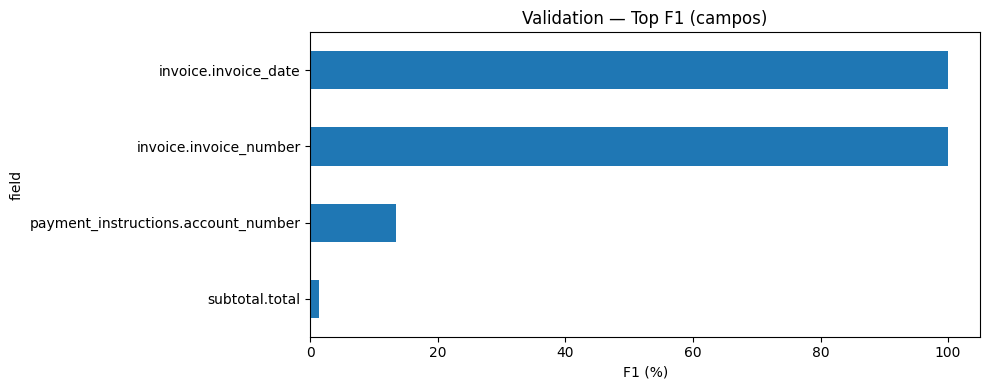

In [ ]:
# [BLOQUE 10] Gráficas
# --------------------
# Requisitos:
# • Barras por campo (Accuracy y F1) para val/test (Top-K)
# • Curva de pérdida por epoch (si hay logs)
# • Check: plt.show() sin errores

import json
from pathlib import Path
from typing import Dict, Any, List, Tuple

import pandas as pd
import matplotlib.pyplot as plt

# ==== 0) Dependencias previas: tablas de métricas de BLOQUE 9 ====
# Intentamos usar VAL_TABLE / TEST_TABLE (producidas en BLOQUE 9).
# Si no existen, recomputamos a partir de VAL_PRED / TEST_PRED usando funciones mínimas.

def _safe_have_tables() -> bool:
    return ("VAL_TABLE" in globals()) and ("TEST_TABLE" in globals())

def _flatten_for_plot(doc: Dict[str, Any], MAX_ITEMS: int = 5) -> Dict[str, Any]:
    out = {}
    inv = (doc.get("invoice") or {})
    for k in ["client_name","client_address","seller_name","seller_address","invoice_number","invoice_date","due_date"]:
        out[f"invoice.{k}"] = inv.get(k)
    subt = (doc.get("subtotal") or {})
    for k in ["tax","discount","total"]:
        out[f"subtotal.{k}"] = subt.get(k)
    pay = (doc.get("payment_instructions") or {})
    for k in ["due_date","bank_name","account_number","payment_method"]:
        out[f"payment_instructions.{k}"] = pay.get(k)
    items = doc.get("items") or []
    if not isinstance(items, list):
        items = [items]
    for i in range(min(len(items), MAX_ITEMS)):
        it = items[i] or {}
        out[f"items[{i}].description"] = it.get("description")
        out[f"items[{i}].quantity"]    = it.get("quantity")
        out[f"items[{i}].total_price"] = it.get("total_price")
    for i in range(len(items), MAX_ITEMS):
        out[f"items[{i}].description"] = None
        out[f"items[{i}].quantity"]    = None
        out[f"items[{i}].total_price"] = None
    return out

def _norm_str(v):
    if v is None: return ""
    return " ".join(str(v).strip().split()).lower()

def _as_float(v):
    if v is None: return None
    try:
        return float(v)
    except Exception:
        s = str(v).strip().replace(",", ".")
        try:
            return float(s)
        except Exception:
            return None

def _eq_value(a, b, eps=1e-2):
    af, bf = _as_float(a), _as_float(b)
    if af is not None and bf is not None:
        return abs(af - bf) <= eps
    return _norm_str(a) == _norm_str(b)

def _is_empty(v):
    if v is None: return True
    if isinstance(v, str): return len(v.strip()) == 0
    return False

def _field_metrics_quick(golds: List[Dict[str, Any]], preds: List[Dict[str, Any]], MAX_ITEMS: int = 5) -> pd.DataFrame:
    flat_g = [_flatten_for_plot(g, MAX_ITEMS) for g in golds]
    flat_p = [_flatten_for_plot(p, MAX_ITEMS) for p in preds]
    keys = sorted(flat_g[0].keys()) if flat_g else []
    rows = []
    for k in keys:
        N = len(golds)
        matches = pred_nonempty = gold_nonempty = 0
        for gi, pi in zip(flat_g, flat_p):
            gv, pv = gi.get(k), pi.get(k)
            g_empty, p_empty = _is_empty(gv), _is_empty(pv)
            if not g_empty: gold_nonempty += 1
            if not p_empty: pred_nonempty += 1
            if (g_empty and p_empty) or _eq_value(gv, pv):
                matches += 1
        acc = matches / N if N else float("nan")
        if pred_nonempty == 0:
            prec = float("nan")
        else:
            tp = sum(1 for gi, pi in zip(flat_g, flat_p)
                     if not _is_empty(pi.get(k)) and _eq_value(gi.get(k), pi.get(k)))
            prec = tp / pred_nonempty
        if gold_nonempty == 0:
            rec = float("nan")
        else:
            tp = sum(1 for gi, pi in zip(flat_g, flat_p)
                     if not _is_empty(gi.get(k)) and _eq_value(gi.get(k), pi.get(k)))
            rec = tp / gold_nonempty
        f1 = (2*prec*rec/(prec+rec)) if (pd.notna(prec) and pd.notna(rec) and (prec+rec)>0) else float("nan")
        rows.append({
            "field": k, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1
        })
    return pd.DataFrame(rows).set_index("field").sort_index()

if not _safe_have_tables():
    assert "VAL_PRED" in globals() and "TEST_PRED" in globals(), "Faltan VAL_PRED/TEST_PRED para recomputar tablas."
    VAL_TABLE = _field_metrics_quick(VAL_PRED["gold_norm"], VAL_PRED["pred_norm"])
    TEST_TABLE = _field_metrics_quick(TEST_PRED["gold_norm"], TEST_PRED["pred_norm"])

# ==== 1) Barras por campo (Top-K) para validation y test ====
def _plot_top_bars(df: pd.DataFrame, metric: str, title: str, top_k: int = 15):
    if df.empty:
        print(f"[WARN] DataFrame vacío para {title}.")
        return
    dfp = df.copy()[[metric]].dropna()
    if dfp.empty:
        print(f"[WARN] No hay valores para {metric} en {title}.")
        return
    dfp = dfp.sort_values(metric, ascending=False).head(top_k)
    plt.figure(figsize=(10, max(4, 0.35*len(dfp))))
    dfp[metric].mul(100).plot(kind="barh")
    plt.gca().invert_yaxis()
    plt.xlabel(f"{metric.upper()} (%)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

print("[INFO] Graficando barras por campo (Validation/Test)...")
_plot_top_bars(VAL_TABLE, "f1",       "Validation — Top F1 (campos)", top_k=15)


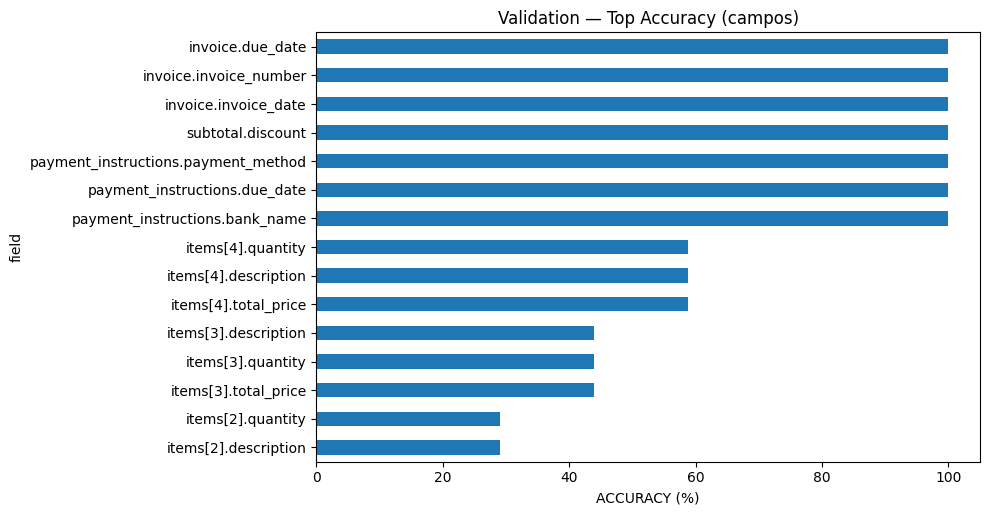

In [ ]:
_plot_top_bars(VAL_TABLE, "accuracy", "Validation — Top Accuracy (campos)", top_k=15)

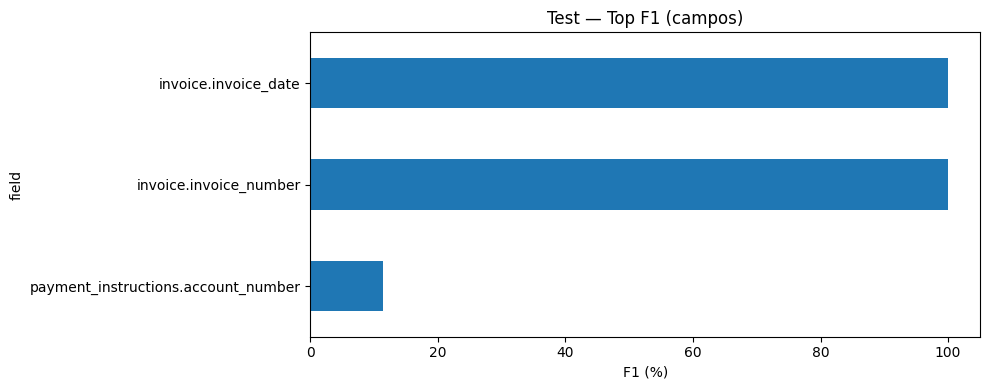

In [ ]:
_plot_top_bars(TEST_TABLE, "f1",       "Test — Top F1 (campos)", top_k=15)

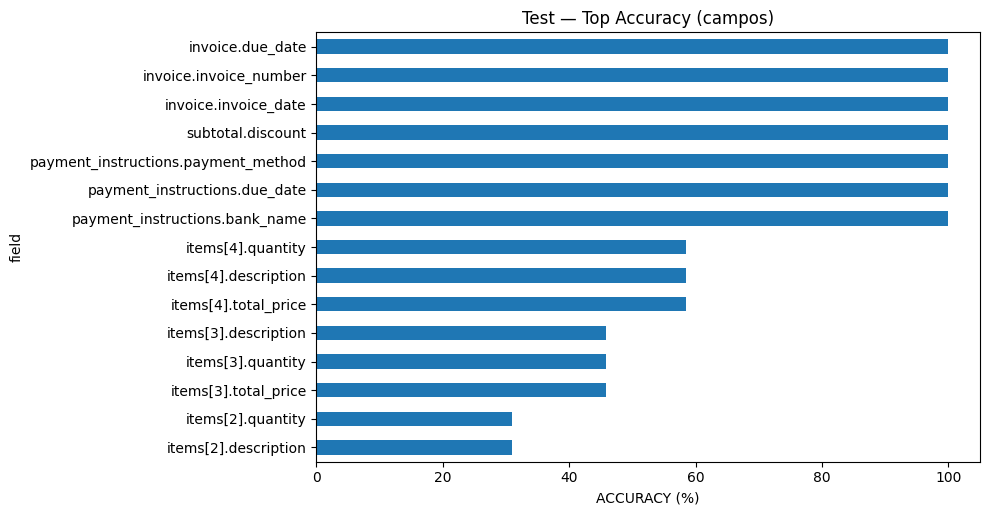

In [ ]:
_plot_top_bars(TEST_TABLE, "accuracy", "Test — Top Accuracy (campos)", top_k=15)

[INFO] Graficando curva de pérdidas (si hay logs)...
[INFO] Usando trainer.state.log_history en memoria.


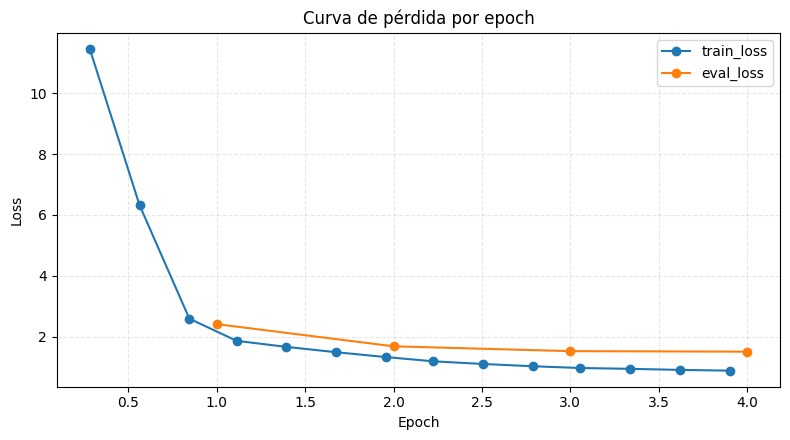


[OK] BLOQUE 10 completado: gráficas generadas y plt.show() ejecutado.


In [ ]:
# ==== 2) Curva de pérdida por epoch (train/eval) ====
# Preferimos: trainer.state.log_history (si trainer sigue en memoria)
# Fallback: artifacts/**/trainer_state.json (guardado por HF Trainer)
def _load_trainer_history() -> List[Dict[str, Any]]:
    # 2.1 si el objeto trainer existe
    if "trainer" in globals() and hasattr(trainer, "state") and hasattr(trainer.state, "log_history"):
        logs = trainer.state.log_history
        if isinstance(logs, list) and len(logs) > 0:
            print("[INFO] Usando trainer.state.log_history en memoria.")
            return logs

    # 2.2 Buscar trainer_state.json en los artefactos más probables
    candidates = [
        Path("artifacts/flan_t5_lora/trainer_state.json"),
        Path("artifacts/flan_t5_base/trainer_state.json"),
        Path("artifacts/flan_t5_base_auto/trainer_state.json"),
        Path("artifacts/trainer_state.json"),
    ]
    for p in candidates:
        if p.exists():
            try:
                with open(p, "r", encoding="utf-8") as f:
                    data = json.load(f)
                logs = data.get("log_history", [])
                if logs:
                    print(f"[INFO] Cargado log_history desde: {p}")
                    return logs
            except Exception as e:
                print(f"[WARN] No se pudo leer {p}: {e}")
    print("[WARN] No se encontró log_history para curvas de pérdida.")
    return []

def _plot_loss_curves(log_history: List[Dict[str, Any]]):
    if not log_history:
        print("[INFO] Sin logs de entrenamiento para graficar pérdidas.")
        return

    # Extraer por epoch: loss (train) y eval_loss
    train_points = [(entry.get("epoch"), entry.get("loss"))
                    for entry in log_history if ("loss" in entry and "epoch" in entry)]
    eval_points  = [(entry.get("epoch"), entry.get("eval_loss"))
                    for entry in log_history if ("eval_loss" in entry and "epoch" in entry)]

    # Consolidar por epoch (tomar último valor de cada época)
    def _last_by_epoch(points: List[Tuple[float, float]]) -> pd.DataFrame:
        if not points: return pd.DataFrame(columns=["epoch","value"])
        dfp = pd.DataFrame(points, columns=["epoch","value"]).dropna()
        # Agrupar por epoch y tomar el último
        return dfp.groupby("epoch", as_index=False)["value"].last().sort_values("epoch")

    df_train = _last_by_epoch(train_points)
    df_eval  = _last_by_epoch(eval_points)

    if df_train.empty and df_eval.empty:
        print("[INFO] Logs no contienen 'loss' ni 'eval_loss' con 'epoch'.")
        return

    plt.figure(figsize=(8, 4.5))
    if not df_train.empty:
        plt.plot(df_train["epoch"], df_train["value"], marker="o", label="train_loss")
    if not df_eval.empty:
        plt.plot(df_eval["epoch"], df_eval["value"], marker="o", label="eval_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Curva de pérdida por epoch")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

print("[INFO] Graficando curva de pérdidas (si hay logs)...")
hist = _load_trainer_history()
_plot_loss_curves(hist)

print("\n[OK] BLOQUE 10 completado: gráficas generadas y plt.show() ejecutado.")


## [BLOQUE 11] Inferencia con texto único

Permite pegar un sample_ocr = """...""" (texto OCR de una factura) y ejecutar toda la tubería: retrieve → plantilla → model.generate → coerción a JSON → validación/normalización (Pydantic). Imprime el JSON validado y verifica que Pydantic no lance excepción.

In [ ]:
# [BLOQUE 11] Inferencia con texto único
# --------------------------------------
# Requisitos:
# • sample_ocr = """...""" parametrizable
# • Llama a generate_json(...) del BLOQUE 8
# • Imprime JSON final (validado/normalizado)
# • Check: la validación Pydantic no debe lanzar excepción

import json
from typing import Any, Dict

# --- Salvaguardas: dependencias de bloques previos ---
assert "generate_json" in globals(), "Falta generate_json del BLOQUE 8."
assert "normalize_json" in globals(), "Falta normalize_json del BLOQUE 3."
assert "InvoiceDoc" in globals(), "Falta el modelo Pydantic InvoiceDoc del BLOQUE 3."

# === 1) Texto de ejemplo (puedes reemplazar libremente) ===
sample_ocr = """
Invoice no: 20012449 Date of issue: 04/22/2013
Seller: Jackson Ltd   Client: Combs Inc
58538 Brandon Union Apt. 536  Taylorshire, PA 90588
433 Ferguson Land Apt. 377    Kirkstad, MN 16124
IBAN: GB17KVLY05129120946380
ITEMS
No. Description                            Qty   Net price   VAT [%]   Gross
1   Press Wine 20L Fruit Cider             1,00  299,00      10%       328,90
2   MARIJUANA LEAF WINE STOPPER            4,00  7,20        10%       31,68
SUMMARY: Net 327,80  Tax 32,78  Total 360,58
"""

# === 2) Utilidad de validación robusta para Pydantic v1/v2 ===
def _validate_with_pydantic(doc: Dict[str, Any]) -> "InvoiceDoc":
    """
    Valida el diccionario contra el esquema InvoiceDoc.
    Soporta Pydantic v1 (parse_obj) y v2 (model_validate).
    """
    # Pydantic v2
    if hasattr(InvoiceDoc, "model_validate"):
        return InvoiceDoc.model_validate(doc)
    # Pydantic v1
    if hasattr(InvoiceDoc, "parse_obj"):
        return InvoiceDoc.parse_obj(doc)
    # Fallback por si cambia la API
    return InvoiceDoc(**doc)

# === 3) Inferencia única + validación ===
def run_single_inference(ocr_text: str, allow_repair: bool = True) -> Dict[str, Any]:
    """
    Ejecuta generate_json() y devuelve un dict normalizado (válido) y metadatos.
    - allow_repair=True activa el fallback de reparación/heurística definido en BLOQUE 8.
    """
    # 3.1 Llamar a generate_json (BLOQUE 8). Contrato: (pred_dict, raw_text, was_repaired)
    pred_dict, raw_text, was_repaired = generate_json(ocr_text, allow_repair=allow_repair)

    # 3.2 Validar/normalizar con nuestro pipeline (BLOQUE 3)
    validated_obj = normalize_json(pred_dict)       # -> InvoiceDoc
    validated_dict = validated_obj.dict() if hasattr(validated_obj, "dict") else validated_obj.model_dump()

    # 3.3 Check explícito: validar de nuevo con Pydantic (no debe fallar)
    _ = _validate_with_pydantic(validated_dict)

    # 3.4 Impresión amigable
    print("=== INFERENCIA: JSON VALIDADO ===")
    print(json.dumps(validated_dict, ensure_ascii=False, indent=2))
    print("\n[CHECK] Pydantic OK (sin excepción).")
    print(f"[INFO] Reparación/heurístico aplicado: {bool(was_repaired)}")
    print("[INFO] Previsualización de salida bruta del modelo (recortada a 400 chars):")
    print((raw_text or "")[:400])

    return {
        "json_validated": validated_dict,
        "raw_output": raw_text,
        "repaired": bool(was_repaired),
    }

# === 4) Ejecutar con el sample_ocr ===
single_pred = run_single_inference(sample_ocr, allow_repair=True)


=== INFERENCIA: JSON VALIDADO ===
{
  "invoice": {
    "client_name": "",
    "client_address": "",
    "seller_name": "jackson ltd client: combs inc",
    "seller_address": "",
    "invoice_number": "20012449",
    "invoice_date": "2013-04-22",
    "due_date": null
  },
  "items": [
    {
      "description": "",
      "quantity": null,
      "total_price": null
    }
  ],
  "subtotal": {
    "tax": null,
    "discount": null,
    "total": 360.58
  },
  "payment_instructions": {
    "due_date": null,
    "bank_name": "",
    "account_number": "gb17kvly05129120946380",
    "payment_method": ""
  }
}

[CHECK] Pydantic OK (sin excepción).
[INFO] Reparación/heurístico aplicado: True
[INFO] Previsualización de salida bruta del modelo (recortada a 400 chars):
{"invoice": {"client_name": null, "client_address": null, "seller_name": "Jackson Ltd   Client: Combs Inc", "seller_address": null, "invoice_number": "20012449", "invoice_date": "04/22/2013", "due_date": null}, "items": [{"description"

<ipython-input-66-af77b5b6d312>:57: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  validated_dict = validated_obj.dict() if hasattr(validated_obj, "dict") else validated_obj.model_dump()


## [BLOQUE 12] Guardado / Carga + Nota de compatibilidad

- Guarda tokenizer y pesos del modelo entrenado (si usaste LoRA, guarda los adapters).
- Proporciona una celda para recargar el modelo (con y sin LoRA) y ejecutar 1 inferencia de prueba.
- Incluye notas de compatibilidad: CPU fallback, límites de memoria y cómo escalar a flan-t5-large cuando haya GPU.

In [ ]:
# [BLOQUE 12] Guardado / Carga y compatibilidad
# ---------------------------------------------
# Requisitos:
# • Guardar tokenizer y pesos (y LoRA si aplica)
# • Celda para recargar y probar 1 inferencia
# • Notas: CPU fallback, memoria, flan-t5-large

from pathlib import Path
import json
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from typing import Dict, Any

# --- Salvaguardas: objetos del entrenamiento ---
assert "MODEL_NAME" in globals(), "Falta MODEL_NAME (BLOQUE 1)."
assert "USE_LORA" in globals(), "Falta USE_LORA (BLOQUE 1)."
assert "tokenizer" in globals(), "Falta tokenizer (BLOQUE 6/7)."
assert "model" in globals(), "Falta model (BLOQUE 7)."

# Directorios de artefactos usados antes
ARTIFACT_DIR = Path("artifacts") / ("flan_t5_lora" if USE_LORA else "flan_t5_base")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

# --- 1) Guardar tokenizer + pesos (adapters si LoRA) ---
print("[INFO] Guardando tokenizer y pesos en:", ARTIFACT_DIR.resolve())
tokenizer.save_pretrained(str(ARTIFACT_DIR))

# Guardado del modelo:
# - Si es LoRA (PEFT): guardamos los adapters (ligeros).
# - Si NO es LoRA: guardamos pesos completos del modelo fine-tuned.
saved_paths: Dict[str, Any] = {}

try:
    # Detectar si el modelo es PEFT (LoRA) sin importar la clase exacta
    is_peft = hasattr(model, "peft_config") or model.__class__.__name__.lower().startswith("peft")
    if is_peft:
        # Guardar SOLO adapters (rápido y liviano)
        model.save_pretrained(str(ARTIFACT_DIR))
        saved_paths["adapters_or_model"] = str(ARTIFACT_DIR)
        saved_paths["type"] = "peft_adapters"
        print("[OK] Adapters LoRA guardados.")
    else:
        # Modelo “full” (sin LoRA)
        model.save_pretrained(str(ARTIFACT_DIR))
        saved_paths["adapters_or_model"] = str(ARTIFACT_DIR)
        saved_paths["type"] = "full_model"
        print("[OK] Modelo completo guardado.")

    # Guardar metadatos mínimos (útil para recarga)
    meta = {
        "model_name_base": MODEL_NAME,
        "use_lora": bool(USE_LORA),
        "device_note": "Saved after training",
    }
    with open(ARTIFACT_DIR / "meta.json", "w", encoding="utf-8") as f:
        json.dump(meta, f, ensure_ascii=False, indent=2)
    saved_paths["meta"] = str(ARTIFACT_DIR / "meta.json")
    print("[OK] Metadata guardada.")
except Exception as e:
    print("[WARN] Problema guardando artefactos:", e)

print("\n=== RESUMEN GUARDADO ===")
print(json.dumps(saved_paths, indent=2, ensure_ascii=False))


[INFO] Guardando tokenizer y pesos en: /content/artifacts/flan_t5_lora
[OK] Adapters LoRA guardados.
[OK] Metadata guardada.

=== RESUMEN GUARDADO ===
{
  "adapters_or_model": "artifacts/flan_t5_lora",
  "type": "peft_adapters",
  "meta": "artifacts/flan_t5_lora/meta.json"
}


In [ ]:
# [BLOQUE 12] Cargar y probar 1 inferencia
# ----------------------------------------
# Esta celda recarga el modelo desde artifacts/, maneja CPU fallback,
# y ejecuta una inferencia de prueba con 'generate_json' (del BLOQUE 8).

from peft import PeftModel  # import seguro: solo se usa si hay adapters
import torch

assert "generate_json" in globals(), "Falta generate_json (BLOQUE 8)."

def load_finetuned(art_dir: str | Path, force_device: str | None = None):
    """
    Carga tokenizer y modelo fine-tuned desde 'art_dir'.
    - Si hay adapters LoRA, los aplica al modelo base.
    - CPU fallback si no hay CUDA o si force_device='cpu'.
    Devuelve: (tokenizer, model, device_str, meta)
    """
    art_dir = Path(art_dir)
    meta_path = art_dir / "meta.json"
    if meta_path.exists():
        with open(meta_path, "r", encoding="utf-8") as f:
            meta = json.load(f)
    else:
        meta = {"model_name_base": MODEL_NAME, "use_lora": bool(USE_LORA)}
    base_name = meta.get("model_name_base", MODEL_NAME)
    use_lora_meta = bool(meta.get("use_lora", False))

    # Dispositivo
    if force_device:
        device = force_device
    else:
        device = "cuda:0" if torch.cuda.is_available() else "cpu"

    print(f"[INFO] Cargando tokenizer desde: {art_dir}")
    tok = AutoTokenizer.from_pretrained(str(art_dir), use_fast=True)

    print(f"[INFO] Cargando modelo base: {base_name}")
    base_model = AutoModelForSeq2SeqLM.from_pretrained(base_name)
    base_model.config.use_cache = False

    if use_lora_meta:
        print("[INFO] Detectados adapters LoRA. Aplicando...")
        # Cargar adapters entrenados desde art_dir sobre el base_model
        model = PeftModel.from_pretrained(base_model, str(art_dir))
    else:
        print("[INFO] No-LoRA: Cargando pesos completos fine-tuned desde artifacts.")
        # Si entrenaste sin LoRA, el art_dir ya contiene los pesos actualizados
        model = AutoModelForSeq2SeqLM.from_pretrained(str(art_dir))
        model.config.use_cache = False

    model = model.to(device)
    print(f"[OK] Modelo en {device}.")
    return tok, model, device, meta

# --- Carga desde el directorio detectado en la celda anterior ---
LOAD_DIR = ARTIFACT_DIR  # reusar el de guardado; cambia si quieres otro
print("[INFO] Re-cargando desde:", LOAD_DIR.resolve())

re_tok, re_model, re_device, re_meta = load_finetuned(LOAD_DIR)

# --- Prueba de inferencia (rápida) ---
sample_ocr_12 = """
Invoice no: 20012449 Date of issue: 04/22/2013
Seller: Jackson Ltd   Client: Combs Inc
58538 Brandon Union Apt. 536, Taylorshire, PA 90588
433 Ferguson Land Apt. 377, Kirkstad, MN 16124
IBAN: GB17KVLY05129120946380
ITEMS
1   Press Wine 20L Fruit Cider     1,00   299,00   10%   328,90
2   MARIJUANA LEAF WINE STOPPER    4,00   7,20     10%   31,68
SUMMARY: Net 327,80  Tax 32,78  Total 360,58
"""

# generate_json usa model/tokenizer globales.
# Para esta prueba temporal, sobre-estructuramos variables globales con la recarga:
_old_model, _old_tok = globals().get("model", None), globals().get("tokenizer", None)
model, tokenizer = re_model, re_tok  # usar los recargados

try:
    pred_dict, raw_text, was_repaired = generate_json(sample_ocr_12, allow_repair=True)
    # Validar con nuestro normalizador (BLOQUE 3):
    assert "normalize_json" in globals() and "InvoiceDoc" in globals()
    validated_obj = normalize_json(pred_dict)
    validated_dict = validated_obj.dict() if hasattr(validated_obj, "dict") else validated_obj.model_dump()

    print("\n=== INFERENCIA (post-reload) — JSON VALIDADO ===")
    print(json.dumps(validated_dict, ensure_ascii=False, indent=2))
    print(f"\n[INFO] Reparación/heurístico aplicado: {bool(was_repaired)}")
    print("[INFO] Raw (preview):", (raw_text or "")[:300])
    print("[OK] Carga + inferencia: correcto.")
finally:
    # Restaurar referencias globales originales si existían
    if _old_model is not None: globals()["model"] = _old_model
    if _old_tok   is not None: globals()["tokenizer"] = _old_tok


[INFO] Re-cargando desde: /content/artifacts/flan_t5_lora
[INFO] Cargando tokenizer desde: artifacts/flan_t5_lora
[INFO] Cargando modelo base: google/flan-t5-base
[INFO] Detectados adapters LoRA. Aplicando...
[OK] Modelo en cuda:0.

=== INFERENCIA (post-reload) — JSON VALIDADO ===
{
  "invoice": {
    "client_name": "",
    "client_address": "",
    "seller_name": "jackson ltd client: combs inc",
    "seller_address": "",
    "invoice_number": "20012449",
    "invoice_date": "2013-04-22",
    "due_date": null
  },
  "items": [
    {
      "description": "",
      "quantity": null,
      "total_price": null
    }
  ],
  "subtotal": {
    "tax": null,
    "discount": null,
    "total": 360.58
  },
  "payment_instructions": {
    "due_date": null,
    "bank_name": "",
    "account_number": "gb17kvly05129120946380",
    "payment_method": ""
  }
}

[INFO] Reparación/heurístico aplicado: True
[INFO] Raw (preview): {"invoice": {"client_name": null, "client_address": null, "seller_name": "Jack

<ipython-input-68-faa9ef0a85d8>:84: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  validated_dict = validated_obj.dict() if hasattr(validated_obj, "dict") else validated_obj.model_dump()
